# 🧬 Binding Pocket Prediction from Protein Sequences

## Introduction
This notebook implements a reproducible workflow for predicting protein binding pockets using sequence data aligned with BioLiP annotations. The goal is to generate residue‑level pocket masks and train neural network models that can classify each amino acid as part of a binding site or not.  

We compare two approaches:
- **Simple Tokenizer + Feedforward Neural Network**: a lightweight model using a custom amino acid vocabulary.
- **ProtBERT Tokenizer + Transformer Head**: leveraging pretrained embeddings for protein sequences.

The workflow includes:
1. Loading protein sequences and BioLiP annotations  
2. Aligning sequences to generate binding pocket masks  
3. Tokenizing sequences (simple vs ProtBERT)  
4. Training and evaluating neural network models  
5. Visualizing performance with ROC curves and AUC metrics  

In [1]:
import torch, sys

print("Python:", sys.version)
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA compiled:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
if torch.cuda.is_available():
    print("GPU count:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}:", torch.cuda.get_device_name(i))
else:
    print("No CUDA-visible device in this environment.")


Python: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
Torch version: 2.6.0+cu124
CUDA available: True
CUDA compiled: 12.4
cuDNN version: 90100
GPU count: 1
Device 0: NVIDIA GeForce RTX 4090 Laptop GPU


## Preprocessing: Aligning BioLiP Annotations with Protein Sequences

This section prepares the dataset by combining protein sequences from FASTA files with binding site annotations from the BioLiP database. The workflow includes:

- **Canonical ID normalization**: Ensures consistent identifiers for PDB entries and chain IDs (e.g., `1abc_A` → `1abc_a`).
- **FASTA parsing**: Reads compressed FASTA sequences and extracts protein chains into a dictionary keyed by canonical IDs.
- **BioLiP parsing**: Reads compressed BioLiP annotations, extracts binding residues from column 9, and converts them into 0‑based indices.
- **Label generation**: For each protein sequence, creates a binary mask (`0` = non‑binding, `1` = binding) aligned to the sequence length.
- **Dataset assembly**: Writes labeled sequences to `biolip_labeled.txt` in a 3‑line format (`>id`, sequence, label mask), then reloads them into memory as `(sequence, labels)` pairs.
- **Debug statistics**: Prints counts of parsed sequences, annotated chains, overlapping IDs, and basic sanity checks (sequence length vs. label length, number of binding residues).

This preprocessing step produces a reproducible dataset that can be used for training and evaluating binding pocket prediction models.

In [2]:
%%time

from Bio import SeqIO
import gzip
import numpy as np

# Canonical ID helper: use consistently for sequences & binding_map
def canonical_id(pdb_id, chain_id):
    """
    Normalize a PDB+chain ID to a consistent form, e.g. '1abc_A' -> '1abc_a'.
    """
    return f"{pdb_id.lower()}_{chain_id.lower()}"

# Load protein sequences
def load_fasta_sequences(fasta_path):
    sequences = {}
    with gzip.open(fasta_path, "rt") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            raw_id = record.id.split()[0]  # remove any trailing description

            # ---- ID PARSING: this may need adjusting depending on your FASTA headers ----
            # First, handle simple "1abcA" style IDs
            if "_" not in raw_id and len(raw_id) >= 5:
                pdb_id = raw_id[:4]
                chain_id = raw_id[4:]
            # If there *is* an underscore, assume "1abc_A" style and use first 4 chars as pdb,
            # first char after "_" as chain, ignore trailing stuff
            elif "_" in raw_id:
                left, right = raw_id.split("_", 1)
                pdb_id = left[:4]
                chain_id = right[0] if len(right) > 0 else "A"
            else:
                # Anything weird, skip
                continue

            key = canonical_id(pdb_id, chain_id)
            sequences[key] = str(record.seq)
    return sequences

# Parse BioLiP.txt
def parse_biolip_annotations(biolip_path):
    """
    Returns:
        binding_map: dict[canonical_id] -> set(0-based residue indices)

    Uses column 9 from BioLiP (binding residues renumbered starting from 1),
    as described in the official readme.txt.
    """
    binding_map = {}

    with gzip.open(biolip_path, "rt") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue

            # BioLiP is tab-delimited
            parts = line.split("\t")
            # According to the readme, there are 21 columns; we just need the first 9+
            if len(parts) < 9:
                continue

            pdb_id = parts[0]          # column 1
            chain_id = parts[1]        # column 2
            key = canonical_id(pdb_id, chain_id)

            # Column 9 (index 8): binding residues, renumbered starting from 1
            # Example: "N73 L74 A75 V108 H111 ..."
            binding_field = parts[8]

            indices = []
            for token in binding_field.split():
                # Tokens are usually like "N73" or "A182". Extract the numeric part.
                digits = "".join(ch for ch in token if ch.isdigit())
                if not digits:
                    continue
                idx = int(digits) - 1   # convert from 1-based → 0-based
                if idx >= 0:
                    indices.append(idx)

            if not indices:
                continue

            # Merge indices if the same chain appears multiple times
            binding_map.setdefault(key, set()).update(indices)

    return binding_map

# Generate labeled output
def generate_labeled_sequences(sequences, binding_map, output_path):
    with open(output_path, "w") as out:
        for protein_id, seq in sequences.items():
            if protein_id not in binding_map:
                continue
            labels = ["0"] * len(seq)
            for idx in binding_map[protein_id]:
                if 0 <= idx < len(seq):
                    labels[idx] = "1"
            out.write(f">{protein_id}\n{seq}\n{''.join(labels)}\n")

# Paths to your files
fasta_path = "protein.fasta.gz"
biolip_path = "BioLiP.txt.gz"
output_path = "biolip_labeled.txt"

# Run preprocessing
sequences = load_fasta_sequences(fasta_path)
binding_map = parse_biolip_annotations(biolip_path)
generate_labeled_sequences(sequences, binding_map, output_path)

def load_labeled_dataset(labeled_path):
    """
    Read the labeled BioLiP file and return a list of (sequence, labels).
    Assumes the file is in repeating 3-line blocks:
      >protein_id
      SEQUENCE
      001010...
    """
    dataset = []
    with open(labeled_path) as f:
        # Remove empty lines to avoid misalignment
        raw_lines = f.read().splitlines()
        lines = [ln for ln in raw_lines if ln.strip()]

    if len(lines) % 3 != 0:
        print(f"Warning: labeled file has {len(lines)} non-empty lines, "
              f"which is not a multiple of 3. Truncating the last incomplete record.")

    # Go only up to len(lines)-2 so i+1 and i+2 are always valid
    for i in range(0, len(lines) - 2, 3):
        header = lines[i]
        if not header.startswith(">"):
            raise ValueError(f"Expected header starting with '>' at line {i}, got: {header!r}")

        protein_id = header[1:]   # remove ">"
        seq = lines[i + 1]
        labels_line = lines[i + 2]

        labels = np.array([int(x) for x in labels_line])
        # Sanity check: labels and sequence must match in length
        if len(labels) != len(seq):
            raise ValueError(
                f"Length mismatch for {protein_id}: seq={len(seq)}, labels={len(labels)}"
            )

        dataset.append((seq, labels))

    return dataset

# Now actually set it
output_path = "biolip_labeled.txt"
dataset = load_labeled_dataset(output_path)

# --- Debug stats so we can see what's going on ---
print("Total sequences parsed from FASTA:", len(sequences))
print("Total chains with binding annotations:", len(binding_map))
common_ids = set(sequences.keys()) & set(binding_map.keys())
print("Number of overlapping IDs:", len(common_ids))
print("Example overlapping IDs:", list(common_ids)[:10])

print("Dataset size:", len(dataset))
if len(dataset) > 0:
    print("First entry sequence length:", len(dataset[0][0]))
    print("First entry labels sum (pocket residues):", np.sum(dataset[0][1]))
else:
    print("No labeled sequences were written to biolip_labeled.txt")


Total sequences parsed from FASTA: 475001
Total chains with binding annotations: 474607
Number of overlapping IDs: 474607
Example overlapping IDs: ['1h5m_a', '9byw_c', '7rro_od', '1vvj_r6', '1zp4_b', '6ezf_a', '4jgv_a', '8j07_tg', '6b9a_a', '6l4u_c']
Dataset size: 474607
First entry sequence length: 154
First entry labels sum (pocket residues): 8
CPU times: total: 32.4 s
Wall time: 33.1 s


## Model Definition and Sequence Encoding

In this section we define the **PocketPredictor** neural network and prepare a query protein sequence for prediction:

- **Amino acid vocabulary**: We specify the 20 canonical amino acids (`AA_VOCAB`) and build a mapping (`aa_to_idx`) from each amino acid to its integer index.
- **PocketPredictor architecture**:
  - Embedding layer: Converts amino acid indices into dense vectors of dimension 64.
  - Feedforward layers: A hidden layer of size 128 with ReLU activation, followed by a linear output layer.
  - Sigmoid activation: Produces residue‑level probabilities between 0 and 1, indicating likelihood of being part of a binding pocket.
- **Sequence validation**: The input sequence is checked to ensure all residues are present in the defined vocabulary.
- **Encoding**: The sequence is converted into integer indices (`input_ids`) suitable for the embedding layer.
- **Sanity check**: The encoded indices are decoded back into amino acids to confirm correctness, and the first 30 token IDs are printed for inspection.

This prepares the model and input representation so that the neural network can later be trained and evaluated on labeled BioLiP data.

In [3]:
%%time

import torch
import torch.nn as nn
import numpy as np

# Amino acid vocabulary (20 standard AAs)
AA_VOCAB = "ACDEFGHIKLMNPQRSTVWY"
aa_to_idx = {aa: i for i, aa in enumerate(AA_VOCAB)}

class PocketPredictor(nn.Module):
    def __init__(self, vocab_size=20, embed_dim=64, hidden_dim=128):
        super().__init__()
        # Embedding layer for amino acids
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # Simple feedforward layers
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids):
        # input_ids: [batch, seq_len]
        x = self.embedding(input_ids)           # [batch, seq_len, embed_dim]
        x = self.fc1(x)                         # [batch, seq_len, hidden_dim]
        x = self.relu(x)
        x = self.fc2(x)                         # [batch, seq_len, 1]
        return self.sigmoid(x).squeeze(-1)      # [batch, seq_len]

# Your query sequence (the one you want to predict pockets on)
sequence = "RRRRSVQWCAVSQPEATKCFQWQRNMRKVRGPPVSCIKRDSPIQCIQAIAENRADAVTLDGGFIYEAGLAPYKLRPVAAEVYGTERQPRTHYYAVAVVKKGGSFQLNELQGLKSCHTGLRRTAGWNVPIGTLRPFLNWTGPPEPIEAAVARFFSASCVPGADKGQFPNLCRLCAGTGENKCAFSSQEPYFSYSGAFKCLRDGAGDVAFIRESTVFEDLSDEAERDEYELLCPDNTRKPVDKFKDCHLARVPSHAVVARSVNGKEDAIWNLLRQAQEKFGKDKSPKFQLFGSPSGQKDLLFKDSAIGFSRVPPRIDSGLYLGSGYFTAIQNLRKSEEEVAARRARVVWCAVGEQELRKCNQWSGLSEGSVTCSSASTTEDCIALVLKGEADAMSLDEGYVYTAGKCGLVPVLAENYKSQQSSDPDPNCVDRPVEGYLAVAVVRRSDTSLTWNSVKGKKSCHTAVDRTAGWNIPMGLLFNQTGSCKFDEYFSQSCAPGSDPRSNLCALCIGDEQGENKCVPNSNERYYGYTGAFRCLAENAGDVAFVKDVTVLQNTDGNNNEAWAKDLKLADFALLCLDGKRKPVTEARSCHLAMAPNHAVVSRMDKVERLKQVLLHQQAKFGRNGSDCPDKFCLFQSETKNLLFNDNTECLARLHGKTTYEKYLGPQYVAGITNLKKCSTSPLLEACEFLRK"

# Check that the sequence only contains amino acids in our vocab
invalid_aas = sorted({aa for aa in sequence if aa not in AA_VOCAB})
if invalid_aas:
    raise ValueError(f"Sequence contains unknown AAs not in AA_VOCAB: {invalid_aas}")

# Encode to indices
input_ids = torch.tensor([[aa_to_idx[aa] for aa in sequence]], dtype=torch.long)

print("Input shape:", input_ids.shape)

# Decode back just to sanity-check mapping
decoded_seq = "".join(AA_VOCAB[idx] for idx in input_ids[0].tolist())
print("Decoded sequence matches original:", decoded_seq == sequence)
print("First 30 token IDs:", input_ids[0][:30].tolist())

Input shape: torch.Size([1, 691])
Decoded sequence matches original: True
First 30 token IDs: [14, 14, 14, 14, 15, 17, 13, 18, 1, 0, 17, 15, 13, 12, 3, 0, 16, 8, 1, 4, 13, 18, 13, 14, 11, 10, 14, 8, 17, 14]
CPU times: total: 0 ns
Wall time: 1 ms


## Candidate Sequence Filtering and Similarity Scoring

This section identifies candidate protein sequences from BioLiP that are most similar to the query sequence, using k‑mer overlap as a measure of similarity.

- **Normalized k‑mer score**:  
  - Sequences are broken into overlapping k‑mers (default `k=3`).  
  - The similarity score is computed as the fraction of shared k‑mers normalized by the smaller sequence size.  
  - This provides a length‑independent measure of sequence similarity.

- **Filtering criteria**:  
  - Only sequences with binding annotations in BioLiP are considered.  
  - Sequences must have a length ratio between 0.3× and 10× relative to the query sequence to avoid extreme mismatches.

- **Ranking candidates**:  
  - Each candidate sequence is scored against the query using the normalized k‑mer metric.  
  - Scores are sorted in descending order, and the top 50 candidates are retained.

- **Debug outputs**:  
  - Total number of sequences parsed.  
  - Number surviving the binding annotation filter.  
  - Number surviving the length filter.  
  - Final candidate count.  
  - Top 10 candidates with their similarity scores.

This step narrows down the dataset to a manageable set of sequences most relevant for downstream binding pocket prediction and model evaluation.

In [4]:
%%time

from collections import Counter

def normalized_kmer_score(seq1, seq2, k=3):
    kmers1 = Counter(seq1[i:i+k] for i in range(len(seq1)-k+1))
    kmers2 = Counter(seq2[i:i+k] for i in range(len(seq2)-k+1))
    shared = sum((kmers1 & kmers2).values())
    denom = min(sum(kmers1.values()), sum(kmers2.values()))
    return shared / denom if denom > 0 else 0.0

scores = []
total = len(sequences)
with_binding = 0
with_length = 0

for pid, target_seq in sequences.items():
    # sequences and binding_map now share the same canonical IDs
    if pid not in binding_map:
        continue
    with_binding += 1

    ratio = len(target_seq) / len(sequence)
    if ratio < 0.3 or ratio > 10.0:
        continue
    with_length += 1

    score = normalized_kmer_score(sequence, target_seq, k=3)
    scores.append((pid, score))

scores.sort(key=lambda x: x[1], reverse=True)
top_candidates = scores[:50]

print("Total sequences:", total)
print("Survive binding filter (existence only):", with_binding)
print("Survive length filter:", with_length)
print("Final candidates:", len(scores))
print("Top 10 candidates:", top_candidates[:10])


Total sequences: 475001
Survive binding filter (existence only): 474607
Survive length filter: 263046
Final candidates: 263046
Top 10 candidates: [('1bka_a', 0.9956268221574344), ('7n88_b', 0.9956268221574344), ('1cb6_a', 0.9941944847605225), ('1fck_a', 0.9912917271407837), ('2pms_a', 0.9908814589665653), ('2pms_b', 0.9908814589665653), ('1lct_a', 0.9906832298136646), ('1h44_a', 0.990625), ('1b0l_a', 0.9898403483309144), ('2bjj_x', 0.9869375907111756)]
CPU times: total: 1min 4s
Wall time: 1min 6s


## Local Sequence Alignment for Best Candidate Match

This step refines the candidate selection by performing **local sequence alignment** between the query protein and each of the top candidates identified in the k‑mer similarity step.

- **Alignment method**:  
  - Uses Biopython’s `pairwise2.align.localms` function.  
  - Scoring scheme: match = +2, mismatch = −1, gap open = −0.5, gap extend = −0.1.  
  - Only the best alignment per candidate is computed (`one_alignment_only=True`).

- **Process**:  
  - Iterates through the top candidate sequences.  
  - Computes the local alignment score against the query sequence.  
  - Tracks the candidate with the highest alignment score.

- **Outputs**:  
  - The identifier (`best_match`) of the sequence most similar to the query.  
  - The corresponding local alignment score (`best_score`).

This alignment step ensures that the final candidate chosen for downstream binding pocket analysis is not only similar at the k‑mer level but also exhibits strong local sequence similarity to the query.

In [5]:
%%time

from Bio import pairwise2
from Bio.Seq import Seq

best_match = None
best_score = -1

for pid, _ in top_candidates:
    target_seq = sequences[pid]
    alignments = pairwise2.align.localms(sequence, target_seq,
                                         2, -1, -0.5, -0.1,
                                         one_alignment_only=True)
    score = alignments[0].score
    if score > best_score:
        best_score = score
        best_match = pid

print("Best match after prefilter:", best_match)
print("Local alignment score:", best_score)


c:\Users\xincr\OneDrive\Desktop\protLLM-2\.venv\Lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Best match after prefilter: 1cb6_a
Local alignment score: 1377.0
CPU times: total: 3.42 s
Wall time: 4.59 s


## Global Alignment and Binding Label Transfer

This step transfers binding site annotations from a template sequence (with BioLiP binding indices) onto the query sequence using **global sequence alignment**.

- **Function `transfer_binding_labels`**:
  - Performs a global alignment between the query and template sequences using Biopython’s `pairwise2.align.globalms`.
  - Scoring scheme: match = +2, mismatch = −1, gap open = −5, gap extend = −1.
  - Iterates through aligned residues:
    - Tracks template positions (skipping gaps).
    - Assigns a binary label (`1` = binding residue, `0` = non‑binding) to each aligned query residue based on whether the corresponding template position is annotated in BioLiP.

- **Outputs**:
  - `y_true_global`: a NumPy array of binding pocket labels aligned to the query sequence.
  - `alignment`: the alignment object containing aligned query and template strings and the alignment score.

- **Debug prints**:
  - First 120 characters of the aligned query and template sequences.
  - Global alignment score.
  - Length of the label array and the number of positive binding residues transferred.

This step ensures that binding pocket annotations from BioLiP can be mapped onto the query sequence in a reproducible, alignment‑aware manner, providing the ground truth labels needed for model training and evaluation.

In [6]:
from Bio import pairwise2
from Bio.Seq import Seq
import numpy as np

def transfer_binding_labels(query_seq, template_seq, binding_indices):
    """
    Global alignment-based transfer:
      - query_seq: your sequence (string or Seq)
      - template_seq: template sequence (string or Seq)
      - binding_indices: set of 0-based residue indices on the template
    """
    alignment = pairwise2.align.globalms(query_seq, template_seq,
                                         2, -1, -5, -1,
                                         one_alignment_only=True)[0]
    aligned_query = alignment.seqA
    aligned_template = alignment.seqB

    y_true = []
    template_pos = -1

    for q_char, t_char in zip(aligned_query, aligned_template):
        if t_char != "-":
            template_pos += 1
        if q_char == "-":
            # gap in query, skip (no label)
            continue
        y_true.append(1 if template_pos in binding_indices else 0)

    return np.array(y_true), alignment

# Example usage with the best_match chosen above
query_seq = Seq(sequence)
template_seq = Seq(sequences[best_match])
binding_indices = binding_map[best_match]   # 0-based indices for this canonical ID

y_true_global, alignment = transfer_binding_labels(query_seq, template_seq, binding_indices)

print("Aligned query (first 120 chars):   ", alignment.seqA)
print("Aligned template (first 120 chars):", alignment.seqB)
print("Global alignment score: ", alignment.score)
print("y_true_global length:", len(y_true_global), "positives:", np.sum(y_true_global))


Aligned query (first 120 chars):    RRRRSVQWCAVSQPEATKCFQWQRNMRKVRGPPVSCIKRDSPIQCIQAIAENRADAVTLDGGFIYEAGLAPYKLRPVAAEVYGTERQPRTHYYAVAVVKKGGSFQLNELQGLKSCHTGLRRTAGWNVPIGTLRPFLNWTGPPEPIEAAVARFFSASCVPGADKGQFPNLCRLCAGTGENKCAFSSQEPYFSYSGAFKCLRDGAGDVAFIRESTVFEDLSDEAERDEYELLCPDNTRKPVDKFKDCHLARVPSHAVVARSVNGKEDAIWNLLRQAQEKFGKDKSPKFQLFGSPSGQKDLLFKDSAIGFSRVPPRIDSGLYLGSGYFTAIQNLRKSEEEVAARRARVVWCAVGEQELRKCNQWSGLSEGSVTCSSASTTEDCIALVLKGEADAMSLDEGYVYTAGKCGLVPVLAENYKSQQSSDPDPNCVDRPVEGYLAVAVVRRSDTSLTWNSVKGKKSCHTAVDRTAGWNIPMGLLFNQTGSCKFDEYFSQSCAPGSDPRSNLCALCIGDEQGENKCVPNSNERYYGYTGAFRCLAENAGDVAFVKDVTVLQNTDGNNNEAWAKDLKLADFALLCLDGKRKPVTEARSCHLAMAPNHAVVSRMDKVERLKQVLLHQQAKFGRNGSDCPDKFCLFQSETKNLLFNDNTECLARLHGKTTYEKYLGPQYVAGITNLKKCSTSPLLEACEFLRK
Aligned template (first 120 chars): GRRRSVQWCAVSQPEATKCFQWQRNMRKVRGPPVSCIKRDSPIQCIQAIAENRADAVTLDGGFIYEAGLAPYKLRPVAAEVYGTERQPRTHYYAVAVVKKGGSFQLNELQGLKSCHTGLRRTAGWNVPIGTLRPFLNWTGPPEPIEAAVARFFSASCVPGADKGQFPNLCRLCAGTGENKCAFSSQEPYFSYSGAFKCLRDGAGDVAFIRESTVFEDLSDEAERDEYELLCPDNTR

## Model Training: PocketPredictor Neural Network

This section trains the **PocketPredictor** model on residue‑level binding pocket labels derived from BioLiP.

- **Device setup**:  
  - Automatically selects GPU (`cuda`) if available, otherwise defaults to CPU.

- **Model configuration**:  
  - Vocabulary size = 20 amino acids.  
  - Embedding dimension = 64.  
  - Hidden layer dimension = 256.  
  - Output: residue‑level binding probability (0–1).

- **Optimization**:  
  - Optimizer: Adam with learning rate `1e-4`.  
  - Loss function: Binary Cross‑Entropy (`BCELoss`), suitable for binary pocket vs. non‑pocket classification.

- **Training parameters**:  
  - Subset of up to 50,000 sequences used for speed (adjustable).  
  - Number of epochs = 2 (can be increased to 5–10 for better convergence).  
  - Training set indices are shuffled to ensure randomness.

- **Training loop**:  
  - Iterates through sequences, skipping any with non‑standard amino acids.  
  - Encodes sequences into integer indices for embedding.  
  - Computes predictions, loss, and performs backpropagation with optimizer updates.  
  - Tracks cumulative loss and reports average loss per epoch.

- **Outputs**:  
  - Device being used (CPU/GPU).  
  - Number of sequences included in training.  
  - Epoch‑by‑epoch training progress with average loss values.

This step fits the neural network to the labeled dataset, enabling it to learn residue‑level binding pocket probabilities from sequence features.

In [7]:
%%time

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

# Make sure AA_VOCAB, aa_to_idx, PocketPredictor, dataset are already defined

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

pocket_model = PocketPredictor(
    vocab_size=len(AA_VOCAB),
    embed_dim=64,
    hidden_dim=256
).to(device)

optimizer = optim.Adam(pocket_model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

# For speed: train on a subset first (you can increase this later)
MAX_TRAIN_SEQS = 50000   # try 10_000 if you want it really quick
NUM_EPOCHS = 2           # bump to 5–10 later if you like

indices = list(range(len(dataset)))
random.shuffle(indices)
train_indices = indices[:MAX_TRAIN_SEQS]

print(f"Training on {len(train_indices)} sequences out of {len(dataset)}")

for epoch in range(NUM_EPOCHS):
    pocket_model.train()
    epoch_loss = 0.0
    used = 0

    for idx in train_indices:
        seq, labels_np = dataset[idx]

        # Skip sequences that contain non-standard AAs
        if any(aa not in aa_to_idx for aa in seq):
            continue

        # Encode sequence into indices 0–19
        inputs = torch.tensor(
            [aa_to_idx[aa] for aa in seq],
            dtype=torch.long,
            device=device
        ).unsqueeze(0)  # [1, L]

        labels = torch.tensor(
            labels_np,
            dtype=torch.float32,
            device=device
        ).unsqueeze(0)  # [1, L]

        optimizer.zero_grad()
        outputs = pocket_model(inputs)  # [1, L]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        used += 1

    avg_loss = epoch_loss / max(used, 1)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, examples used: {used}, avg loss: {avg_loss:.4f}")


Using device: cuda
Training on 50000 sequences out of 474607
Epoch 1/2, examples used: 49999, avg loss: 0.3298
Epoch 2/2, examples used: 49999, avg loss: 0.3291
CPU times: total: 1min 46s
Wall time: 2min


## Model Inference: Predicting Binding Pocket Probabilities

This section runs the trained **PocketPredictor** model on the query sequence to generate residue‑level binding pocket predictions.

- **Sanity check**:  
  - Ensures the query sequence contains only valid amino acids from the defined vocabulary.  
  - Raises an error if any unknown characters are present.

- **Evaluation mode**:  
  - Sets the model to evaluation mode (`pocket_model.eval()`) to disable dropout and gradient updates.  
  - Uses `torch.no_grad()` to prevent gradient tracking during inference.

- **Input preparation**:  
  - Encodes the query sequence into integer indices using the amino acid vocabulary.  
  - Converts the indices into a tensor suitable for the model.

- **Prediction**:  
  - The model outputs residue‑level probabilities (`y_pred_probs`) indicating the likelihood of each amino acid being part of a binding pocket.  
  - Results are returned as a NumPy array for easy inspection and downstream analysis.

- **Outputs**:  
  - Shape of the prediction array (equal to sequence length).  
  - Sample of the first 10 predicted probabilities.

This inference step applies the trained neural network to the query sequence, producing interpretable binding pocket probability scores for each residue.

In [8]:
%%time

# Ensure your 'sequence' string and aa_to_idx are already defined

# Sanity: skip if sequence has unknown AAs
invalid_aas = sorted({aa for aa in sequence if aa not in aa_to_idx})
if invalid_aas:
    raise ValueError(f"Query sequence contains unknown AAs: {invalid_aas}")

pocket_model.eval()
with torch.no_grad():
    input_ids = torch.tensor(
        [[aa_to_idx[aa] for aa in sequence]],
        dtype=torch.long,
        device=device
    )
    y_pred_probs = pocket_model(input_ids).squeeze(0).cpu().numpy()

print("Trained prediction shape:", y_pred_probs.shape)
print("Sample trained predictions:", y_pred_probs[:10])


Trained prediction shape: (691,)
Sample trained predictions: [0.2583297  0.2583297  0.2583297  0.2583297  0.10036238 0.05609597
 0.09925781 0.157051   0.22471663 0.06122833]
CPU times: total: 0 ns
Wall time: 3.43 ms


## Global Alignment-Based Binding Label Transfer

This section maps binding site annotations from a BioLiP template sequence onto the query sequence using **global alignment**.

- **Function `transfer_binding_labels_global`**:
  - Performs a global alignment between the query and template sequences with Biopython’s `pairwise2.align.globalms`.
  - Scoring scheme: match = +2, mismatch = −1, gap open = −5, gap extend = −1.
  - Iterates through aligned residues:
    - Tracks template positions (skipping gaps).
    - Assigns a binary label (`1` = binding residue, `0` = non‑binding) to each aligned query residue based on template annotations.

- **Robustness checks**:
  - Handles off‑by‑one alignment issues by padding or truncating the label array to exactly match the query sequence length.

- **Outputs**:
  - `y_true`: NumPy array of binding pocket labels aligned to the query sequence.
  - `alignment`: Biopython alignment object containing aligned query and template strings and the alignment score.

- **Debug prints**:
  - Length of the label array and number of positive binding residues.
  - Alignment score.
  - Aligned query and template sequences for inspection.

This step ensures that binding pocket annotations from BioLiP are transferred onto the query sequence in a reproducible, alignment‑aware manner, providing the ground truth labels needed for model evaluation.

In [9]:
%%time

from Bio import pairwise2
from Bio.Seq import Seq
import numpy as np

def transfer_binding_labels_global(query_seq, template_seq, binding_indices):
    """
    Global alignment-based label transfer.

    binding_indices: set/list of 0-based residue indices in the *template* sequence.
    Returns:
        y_true: np.array of shape [len(query_seq)], 0/1 per residue.
        alignment: Biopython alignment object.
    """
    alignment = pairwise2.align.globalms(
        query_seq, template_seq,
        2, -1,    # match, mismatch
        -5, -1,   # gap open, gap extend
        one_alignment_only=True
    )[0]

    aligned_query = alignment.seqA
    aligned_template = alignment.seqB

    y_true = []
    template_pos = -1

    for q_char, t_char in zip(aligned_query, aligned_template):
        if t_char != "-":
            template_pos += 1
        if q_char == "-":
            # gap in query: skip (no residue)
            continue
        y_true.append(1 if template_pos in binding_indices else 0)

    y_true = np.array(y_true, dtype=int)

    # If alignment weirdness causes small off-by-one issues, be forgiving:
    if len(y_true) < len(query_seq):
        y_true = np.pad(y_true, (0, len(query_seq) - len(y_true)))
    elif len(y_true) > len(query_seq):
        y_true = y_true[:len(query_seq)]

    return y_true, alignment

# Use your best_match template
query_seq = Seq(sequence)
template_seq = Seq(sequences[best_match])
binding_indices = binding_map[best_match]   # 0-based indices

y_true, alignment = transfer_binding_labels_global(
    query_seq, template_seq, binding_indices
)

print("y_true length:", len(y_true), "positives:", np.sum(y_true))
print("Alignment score:", alignment.score)
print("Alignment:")
print("Query:   ", alignment.seqA)
print("Template:", alignment.seqB)


y_true length: 691 positives: 6
Alignment score: 1376.0
Alignment:
Query:    RRRRSVQWCAVSQPEATKCFQWQRNMRKVRGPPVSCIKRDSPIQCIQAIAENRADAVTLDGGFIYEAGLAPYKLRPVAAEVYGTERQPRTHYYAVAVVKKGGSFQLNELQGLKSCHTGLRRTAGWNVPIGTLRPFLNWTGPPEPIEAAVARFFSASCVPGADKGQFPNLCRLCAGTGENKCAFSSQEPYFSYSGAFKCLRDGAGDVAFIRESTVFEDLSDEAERDEYELLCPDNTRKPVDKFKDCHLARVPSHAVVARSVNGKEDAIWNLLRQAQEKFGKDKSPKFQLFGSPSGQKDLLFKDSAIGFSRVPPRIDSGLYLGSGYFTAIQNLRKSEEEVAARRARVVWCAVGEQELRKCNQWSGLSEGSVTCSSASTTEDCIALVLKGEADAMSLDEGYVYTAGKCGLVPVLAENYKSQQSSDPDPNCVDRPVEGYLAVAVVRRSDTSLTWNSVKGKKSCHTAVDRTAGWNIPMGLLFNQTGSCKFDEYFSQSCAPGSDPRSNLCALCIGDEQGENKCVPNSNERYYGYTGAFRCLAENAGDVAFVKDVTVLQNTDGNNNEAWAKDLKLADFALLCLDGKRKPVTEARSCHLAMAPNHAVVSRMDKVERLKQVLLHQQAKFGRNGSDCPDKFCLFQSETKNLLFNDNTECLARLHGKTTYEKYLGPQYVAGITNLKKCSTSPLLEACEFLRK
Template: GRRRSVQWCAVSQPEATKCFQWQRNMRKVRGPPVSCIKRDSPIQCIQAIAENRADAVTLDGGFIYEAGLAPYKLRPVAAEVYGTERQPRTHYYAVAVVKKGGSFQLNELQGLKSCHTGLRRTAGWNVPIGTLRPFLNWTGPPEPIEAAVARFFSASCVPGADKGQFPNLCRLCAGTGENKCAFSSQEPYFSYSGAFKCLRDGAGDVAFIRESTVFEDLSDE

## Model Evaluation: Binding Pocket Prediction Metrics

This section evaluates the trained **PocketPredictor** model by comparing predicted binding probabilities against ground truth labels transferred from BioLiP.

- **Function `evaluate_pocket_predictions`**:
  - Inputs:  
    - `y_true`: binary ground truth labels (0 = non‑pocket, 1 = pocket).  
    - `y_pred_probs`: predicted probabilities for each residue.  
    - `threshold`: cutoff for converting probabilities into binary predictions (default = 0.5).
  - Checks for shape consistency between labels and predictions.
  - Converts probabilities into binary predictions (`y_pred`) using the threshold.

- **Residue‑level metrics**:
  - **ROC‑AUC**: Area under the ROC curve, threshold‑independent measure of classification performance.  
  - **Precision**: Fraction of predicted pocket residues that are correct.  
  - **Recall**: Fraction of true pocket residues correctly identified.  
  - **F1 score**: Harmonic mean of precision and recall.

- **Pocket‑level metrics**:
  - **Coverage**: Fraction of true pocket residues captured by predictions.  
  - **Overlap**: Fraction of predicted pocket residues that overlap with true pockets.  
  - Counts of true vs. predicted pocket residues.

- **Outputs**:
  - Prints all evaluation metrics with three‑decimal precision for floats.  
  - Provides interpretable measures of both residue‑level accuracy and pocket‑level overlap.

This evaluation step quantifies how well the model identifies binding pocket residues, balancing precision, recall, and overall coverage of annotated binding sites.

In [10]:
%%time

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

def evaluate_pocket_predictions(y_true, y_pred_probs, threshold=0.5):
    """
    Evaluate binding pocket predictions.
    
    Args:
        y_true (np.array): Binary ground truth labels (0 = non-pocket, 1 = pocket)
        y_pred_probs (np.array): Predicted probabilities for each residue
        threshold (float): Classification threshold for binary decision

    Returns:
        dict: Evaluation metrics
    """
    if len(y_true) != len(y_pred_probs):
        raise ValueError(
            f"Shape mismatch: y_true={len(y_true)}, y_pred_probs={len(y_pred_probs)}"
        )

    y_pred = (y_pred_probs > threshold).astype(int)

    # Residue-level metrics
    roc_auc = roc_auc_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Pocket-level coverage / overlap
    true_pocket = set(np.where(y_true == 1)[0])
    predicted_pocket = set(np.where(y_pred == 1)[0])
    intersection = true_pocket & predicted_pocket

    coverage = len(intersection) / len(true_pocket) if true_pocket else 0.0
    overlap = len(intersection) / len(predicted_pocket) if predicted_pocket else 0.0

    return {
        "ROC-AUC": roc_auc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "Pocket Coverage": coverage,
        "Pocket Overlap": overlap,
        "True pocket residues": len(true_pocket),
        "Predicted pocket residues": len(predicted_pocket),
    }

metrics = evaluate_pocket_predictions(y_true, y_pred_probs, threshold=0.5)

for k, v in metrics.items():
    if isinstance(v, float):
        print(f"{k}: {v:.3f}")
    else:
        print(f"{k}: {v}")


ROC-AUC: 0.743
Precision: 0.000
Recall: 0.000
F1: 0.000
Pocket Coverage: 0.000
Pocket Overlap: 0.000
True pocket residues: 6
Predicted pocket residues: 0
CPU times: total: 766 ms
Wall time: 1min 20s


## Prediction Probability Distribution Analysis

This section summarizes the distribution of binding pocket probabilities predicted by the trained model for the query sequence.

- **Minimum / Maximum**: Reports the lowest and highest predicted probabilities across all residues.  
- **Mean**: Provides the average probability, indicating overall model confidence.  
- **Quantiles**: Displays key percentiles (median, 90th, 95th, 99th) to highlight how predictions are spread across residues.

These statistics help assess whether the model outputs are well‑calibrated, skewed toward extremes, or concentrated around certain probability ranges. This diagnostic step complements ROC and precision/recall metrics by showing the raw distribution of prediction scores.

In [11]:
import numpy as np

print("Min prob:", float(y_pred_probs.min()))
print("Max prob:", float(y_pred_probs.max()))
print("Mean prob:", float(y_pred_probs.mean()))
print("Quantiles:", np.quantile(y_pred_probs, [0.5, 0.9, 0.95, 0.99]))


Min prob: 0.056035034358501434
Max prob: 0.25832968950271606
Mean prob: 0.1111350804567337
Quantiles: [0.09959684 0.22471663 0.25832969 0.25832969]


## Threshold-Specific Precision, Recall, and F1 Analysis

This section explores how evaluation metrics change when different probability thresholds are applied to classify residues as binding pockets.

- **Function `metrics_at_threshold`**:
  - Converts predicted probabilities into binary predictions using a specified threshold.  
  - Computes **precision**, **recall**, and **F1 score** at that threshold.  
  - Reports the number of residues predicted as binding (`num_pred`).

- **Threshold sweep**:
  - Evaluates metrics at thresholds 0.1, 0.2, 0.3, 0.4, and 0.5.  
  - Prints precision, recall, F1 score, and count of predicted positives for each threshold.

- **Interpretation**:
  - Lower thresholds increase recall (more residues classified as binding) but may reduce precision.  
  - Higher thresholds increase precision (fewer false positives) but may reduce recall.  
  - The F1 score balances precision and recall, highlighting the trade‑off between sensitivity and specificity.

This threshold analysis provides insight into how model performance varies with decision boundaries, helping select an optimal threshold for practical binding pocket prediction.

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

def metrics_at_threshold(y_true, y_pred_probs, threshold):
    y_pred = (y_pred_probs > threshold).astype(int)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    num_pred = int(y_pred.sum())
    return precision, recall, f1, num_pred

for thr in [0.1, 0.2, 0.3, 0.4, 0.5]:
    p, r, f, n = metrics_at_threshold(y_true, y_pred_probs, thr)
    print(f"thr={thr:.2f} -> P={p:.3f}, R={r:.3f}, F1={f:.3f}, predicted+={n}")


thr=0.10 -> P=0.016, R=0.833, F1=0.032, predicted+=310
thr=0.20 -> P=0.023, R=0.333, F1=0.043, predicted+=86
thr=0.30 -> P=0.000, R=0.000, F1=0.000, predicted+=0
thr=0.40 -> P=0.000, R=0.000, F1=0.000, predicted+=0
thr=0.50 -> P=0.000, R=0.000, F1=0.000, predicted+=0


## Top‑K Residue Prediction Strategy

This section evaluates the model using a **top‑k strategy**, where the number of predicted binding residues is set equal to the number of true binding residues.

- **Approach**:
  - Compute `k` as the number of true binding pocket residues in the ground truth (`y_true.sum()`).
  - Sort predicted probabilities (`y_pred_probs`) in descending order.
  - Select the top‑k residues with the highest predicted probabilities as binding sites.
  - Construct a binary prediction array (`y_pred_topk`) marking these residues as pockets.

- **Evaluation metrics**:
  - **Precision**: Fraction of predicted residues that are true binding sites.  
  - **Recall**: Fraction of true binding residues correctly identified.  
  - **F1 score**: Harmonic mean of precision and recall, balancing both metrics.

- **Outputs**:
  - Precision, recall, and F1 score for the top‑k strategy.  
  - Indices of residues predicted as pockets.  
  - Indices of true pocket residues for comparison.

This evaluation method provides a threshold‑free way to assess model performance by directly matching the number of predicted residues to the number of true binding residues, highlighting how well the model ranks residues by binding likelihood.

In [13]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

k = int(y_true.sum())  # number of true pockets = 6
topk_idx = np.argsort(-y_pred_probs)[:k]  # indices of top-k residues

y_pred_topk = np.zeros_like(y_true)
y_pred_topk[topk_idx] = 1

p = precision_score(y_true, y_pred_topk, zero_division=0)
r = recall_score(y_true, y_pred_topk, zero_division=0)
f1 = f1_score(y_true, y_pred_topk, zero_division=0)

print(f"Top-k strategy (k = {k}):")
print(f"Precision: {p:.3f}, Recall: {r:.3f}, F1: {f1:.3f}")
print("Top-k indices:", topk_idx)
print("True pocket indices:", np.where(y_true == 1)[0])


Top-k strategy (k = 6):
Precision: 0.167, Recall: 0.167, F1: 0.167
Top-k indices: [ 38  52  29  26 464 442]
True pocket indices: [120 122 191 460 464 527]


## PocketPredictorLogits: Logit-Based Model Variant

This section defines a variant of the **PocketPredictor** neural network that outputs raw logits instead of probabilities.

- **Architecture**:
  - **Embedding layer**: Maps amino acid indices into dense vectors of dimension 64.  
  - **Fully connected layers**:  
    - First linear layer projects embeddings into a hidden dimension of 256.  
    - ReLU activation introduces non‑linearity.  
    - Second linear layer reduces hidden features to a single output per residue.  
  - **Output**: Produces raw logits of shape `[batch, seq_len]`.

- **Key difference from PocketPredictor**:
  - This version does **not** apply a sigmoid activation in the forward pass.  
  - Logits can later be converted into probabilities using `torch.sigmoid` during training or evaluation.  
  - This design is often preferred for stability when using loss functions like `BCEWithLogitsLoss`, which internally applies the sigmoid.

This logit‑based variant provides more flexibility for training and evaluation, especially when experimenting with different loss functions or calibration strategies.

In [14]:
import torch.nn as nn

class PocketPredictorLogits(nn.Module):
    def __init__(self, vocab_size=20, embed_dim=64, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, input_ids):
        # [batch, seq_len] -> [batch, seq_len, embed_dim]
        x = self.embedding(input_ids)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)      # [batch, seq_len, 1]
        return x.squeeze(-1) # [batch, seq_len] logits


## Training with Logit-Based Model and Class Imbalance Handling

This section trains the **PocketPredictorLogits** model, which outputs raw logits, using a loss function that accounts for the strong imbalance between binding and non‑binding residues.

- **Device setup**:  
  - Automatically selects GPU (`cuda`) if available, otherwise defaults to CPU.

- **Class imbalance estimation**:  
  - Samples up to 10,000 sequences from the dataset.  
  - Computes the fraction of positive residues (binding pockets) vs. negatives.  
  - Typically, binding residues are rare compared to non‑binding residues.

- **Weighted loss function**:  
  - Calculates `pos_weight = neg_frac / pos_frac`.  
  - This increases the penalty for misclassifying binding residues.  
  - Uses `BCEWithLogitsLoss`, which internally applies the sigmoid to logits and incorporates the class weight.

- **Model setup**:  
  - PocketPredictorLogits instantiated with embedding dimension = 64 and hidden dimension = 256.  
  - Optimizer: Adam (`lr=1e-4`).  
  - Loss: `BCEWithLogitsLoss` with `pos_weight`.

- **Training configuration**:  
  - Subset of up to 50,000 sequences used for efficiency.  
  - Number of epochs = 3.  
  - Training indices are shuffled to ensure randomness.

- **Loop details**:  
  - Iterates through sequences, skipping those with non‑standard amino acids.  
  - Encodes sequences into integer indices for embedding.  
  - Computes logits, applies weighted loss, backpropagates gradients, and updates parameters.  
  - Tracks cumulative loss and reports average loss per epoch.

- **Outputs**:  
  - Estimated positive fraction of residues.  
  - Calculated `pos_weight` value.  
  - Epoch‑by‑epoch training progress with average loss values.

This training strategy improves sensitivity to binding residues by explicitly correcting for class imbalance, making the model more robust in identifying rare pocket positions.

In [15]:
%%time

import torch
import torch.optim as optim
import numpy as np
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Rough estimate of positive / negative ratio on a subset
sample_for_ratio = 10000
all_pos = 0
all_total = 0
for i in random.sample(range(len(dataset)), min(sample_for_ratio, len(dataset))):
    _, labels_np = dataset[i]
    all_pos += labels_np.sum()
    all_total += len(labels_np)

pos_frac = all_pos / all_total
neg_frac = 1.0 - pos_frac
print(f"Estimated positive fraction: {pos_frac:.5f}")

# pos_weight > 1 means we penalize missing a positive more than missing a negative
pos_weight = torch.tensor([neg_frac / max(pos_frac, 1e-6)], device=device)
print("Using pos_weight:", float(pos_weight))

pocket_model2 = PocketPredictorLogits(
    vocab_size=len(AA_VOCAB),
    embed_dim=64,
    hidden_dim=256
).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(pocket_model2.parameters(), lr=1e-4)

MAX_TRAIN_SEQS = 50000
NUM_EPOCHS = 3

indices = list(range(len(dataset)))
random.shuffle(indices)
train_indices = indices[:MAX_TRAIN_SEQS]

print(f"Training (logits model) on {len(train_indices)} sequences out of {len(dataset)}")

for epoch in range(NUM_EPOCHS):
    pocket_model2.train()
    epoch_loss = 0.0
    used = 0

    for idx in train_indices:
        seq, labels_np = dataset[idx]

        if any(aa not in aa_to_idx for aa in seq):
            continue

        inputs = torch.tensor(
            [aa_to_idx[aa] for aa in seq],
            dtype=torch.long,
            device=device
        ).unsqueeze(0)

        labels = torch.tensor(
            labels_np,
            dtype=torch.float32,
            device=device
        ).unsqueeze(0)

        optimizer.zero_grad()
        logits = pocket_model2(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        used += 1

    avg_loss = epoch_loss / max(used, 1)
    print(f"[logits] Epoch {epoch+1}/{NUM_EPOCHS}, examples used: {used}, avg loss: {avg_loss:.4f}")


Using device: cuda
Estimated positive fraction: 0.06390
Using pos_weight: 14.650609884448777
Training (logits model) on 50000 sequences out of 474607
[logits] Epoch 1/3, examples used: 49999, avg loss: 1.5320
[logits] Epoch 2/3, examples used: 49999, avg loss: 1.5304
[logits] Epoch 3/3, examples used: 49999, avg loss: 1.5298
CPU times: total: 2min 53s
Wall time: 3min 18s


## Inference with Logit-Based Model (PocketPredictorLogits)

This section applies the **PocketPredictorLogits** model to the query sequence, converting raw logits into binding pocket probabilities.

- **Sanity check**:  
  - Ensures the query sequence contains only valid amino acids from the defined vocabulary.  
  - Raises an error if any unknown characters are present.

- **Evaluation mode**:  
  - Sets the model to evaluation mode (`pocket_model2.eval()`) to disable dropout and gradient updates.  
  - Uses `torch.no_grad()` to prevent gradient tracking during inference.

- **Input preparation**:  
  - Encodes the query sequence into integer indices using the amino acid vocabulary.  
  - Converts the indices into a tensor suitable for the model.

- **Prediction**:  
  - The model outputs raw logits for each residue.  
  - These logits are passed through a sigmoid function to obtain probabilities (`y_pred_probs2`).  
  - Each probability represents the likelihood of the corresponding residue being part of a binding pocket.

- **Outputs**:  
  - Shape of the prediction array (equal to sequence length).  
  - Minimum, mean, and maximum predicted probabilities across residues.

This inference step demonstrates how the logit‑based model produces calibrated binding pocket probabilities, complementing the earlier probability‑based predictor and enabling more robust evaluation.

In [16]:
%%time

# Predictions on your query sequence using the logits model
invalid_aas = sorted({aa for aa in sequence if aa not in aa_to_idx})
if invalid_aas:
    raise ValueError(f"Query sequence contains unknown AAs: {invalid_aas}")

pocket_model2.eval()
with torch.no_grad():
    input_ids = torch.tensor(
        [[aa_to_idx[aa] for aa in sequence]],
        dtype=torch.long,
        device=device
    )
    logits = pocket_model2(input_ids)  # [1, L]
    y_pred_probs2 = torch.sigmoid(logits).squeeze(0).cpu().numpy()

print("New prediction shape:", y_pred_probs2.shape)
print("New prob stats -> min/mean/max:",
      float(y_pred_probs2.min()),
      float(y_pred_probs2.mean()),
      float(y_pred_probs2.max()))


New prediction shape: (691,)
New prob stats -> min/mean/max: 0.4914252758026123 0.6151523590087891 0.8311325907707214
CPU times: total: 0 ns
Wall time: 1e+03 μs


## Evaluation of Logit-Based Model with Class Weighting

This section evaluates the **PocketPredictorLogits** model, trained with a weighted loss to address class imbalance, on the query sequence.

- **Evaluation setup**:
  - Uses the same ground truth binding pocket labels (`y_true`) transferred from BioLiP.  
  - Predictions (`y_pred_probs2`) are generated by applying a sigmoid to the model’s logits.  
  - Threshold for classification is set to **0.2**, reflecting the need for higher sensitivity to rare binding residues.

- **Metrics computed**:
  - **ROC‑AUC**: Threshold‑independent measure of classification performance.  
  - **Precision**: Fraction of predicted pocket residues that are correct.  
  - **Recall**: Fraction of true pocket residues correctly identified.  
  - **F1 score**: Harmonic mean of precision and recall.  
  - **Pocket coverage**: Fraction of true pocket residues captured by predictions.  
  - **Pocket overlap**: Fraction of predicted pocket residues overlapping with true pockets.  
  - Counts of true vs. predicted pocket residues.

- **Outputs**:
  - Prints all evaluation metrics with three‑decimal precision for floats.  
  - Provides interpretable measures of both residue‑level accuracy and pocket‑level overlap.

This evaluation demonstrates how weighting positive residues during training influences model sensitivity and specificity, offering a more balanced performance on rare binding pocket positions.

In [17]:
metrics2 = evaluate_pocket_predictions(y_true, y_pred_probs2, threshold=0.2)

print("\nMetrics with logits + pos_weight (threshold=0.2):")
for k, v in metrics2.items():
    if isinstance(v, float):
        print(f"{k}: {v:.3f}")
    else:
        print(f"{k}: {v}")



Metrics with logits + pos_weight (threshold=0.2):
ROC-AUC: 0.702
Precision: 0.009
Recall: 1.000
F1: 0.017
Pocket Coverage: 1.000
Pocket Overlap: 0.009
True pocket residues: 6
Predicted pocket residues: 691


## Threshold Sweep for Logit-Based Model Predictions

This section evaluates how the **PocketPredictorLogits** model’s performance changes across different probability thresholds.

- **Approach**:
  - Uses the helper function `metrics_at_threshold` to compute metrics at each threshold.  
  - Thresholds tested: 0.1, 0.2, 0.3, 0.4, and 0.5.  
  - Converts predicted probabilities into binary pocket/non‑pocket calls at each threshold.

- **Metrics reported**:
  - **Precision**: Fraction of predicted pocket residues that are correct.  
  - **Recall**: Fraction of true pocket residues correctly identified.  
  - **F1 score**: Harmonic mean of precision and recall.  
  - **Predicted+ count**: Number of residues classified as binding pockets at that threshold.

- **Interpretation**:
  - Lower thresholds increase recall (more residues classified as pockets) but may reduce precision.  
  - Higher thresholds increase precision (fewer false positives) but may reduce recall.  
  - The F1 score highlights the balance point between precision and recall.  
  - The predicted+ count shows how aggressive the model is at each threshold.

This threshold sweep provides a practical view of the trade‑offs between sensitivity and specificity, helping identify an optimal threshold for binding pocket prediction in real applications.

In [18]:
for thr in [0.1, 0.2, 0.3, 0.4, 0.5]:
    p, r, f, n = metrics_at_threshold(y_true, y_pred_probs2, thr)
    print(f"thr={thr:.2f} -> P={p:.3f}, R={r:.3f}, F1={f:.3f}, predicted+={n}")


thr=0.10 -> P=0.009, R=1.000, F1=0.017, predicted+=691
thr=0.20 -> P=0.009, R=1.000, F1=0.017, predicted+=691
thr=0.30 -> P=0.009, R=1.000, F1=0.017, predicted+=691
thr=0.40 -> P=0.009, R=1.000, F1=0.017, predicted+=691
thr=0.50 -> P=0.010, R=0.833, F1=0.021, predicted+=480


## Transformer-Based Model Setup

This section initializes the environment for experimenting with **transformer architectures** (via Hugging Face’s `transformers` library) as an alternative to the custom PocketPredictor models.

- **Imports**:
  - `AutoTokenizer` and `AutoModel` from Hugging Face for loading pretrained transformer models.  
  - PyTorch modules (`nn`, `optim`, `Dataset`, `DataLoader`) for defining and training neural networks.  
  - NumPy and `random` for numerical operations and reproducibility.

- **Device setup**:
  - Automatically detects GPU (`cuda`) if available, otherwise defaults to CPU.  
  - Prints the device being used for training and inference.

This setup prepares the notebook to integrate transformer‑based sequence models, enabling comparison between custom architectures (PocketPredictor) and pretrained transformer embeddings for binding pocket prediction.

In [19]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Loading ProtBERT for Protein Sequence Embeddings

This section integrates a **pretrained transformer model** (ProtBERT) from Hugging Face to generate protein sequence embeddings.

- **Model choice**:  
  - `Rostlab/prot_bert` is a transformer model trained specifically on large protein sequence datasets.  
  - It captures contextual amino acid representations, enabling downstream tasks like binding pocket prediction.

- **Tokenizer**:  
  - Converts raw protein sequences into tokenized inputs compatible with ProtBERT.  
  - `do_lower_case=False` ensures amino acid characters are preserved exactly as provided.

- **Model**:  
  - Loads the pretrained ProtBERT model (`AutoModel`).  
  - Moves the model to the selected device (GPU if available, otherwise CPU).  
  - Prints the hidden size of the model, which defines the dimensionality of the embeddings produced for each token.

This step prepares ProtBERT as a feature extractor, allowing protein sequences to be embedded into high‑dimensional representations that can be used for downstream classification or binding site prediction tasks.

In [20]:
from transformers import AutoTokenizer, AutoModel

MODEL_NAME = "Rostlab/prot_bert"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
base_model = AutoModel.from_pretrained(MODEL_NAME).to(device)
print("Hidden size:", base_model.config.hidden_size)


Hidden size: 1024


## ProtBERT-Pocket: Transformer-Based Binding Pocket Predictor

This section defines a **neural network architecture** that leverages pretrained ProtBERT embeddings for residue‑level binding pocket prediction.

- **Architecture**:
  - **Base model**: A pretrained ProtBERT transformer (`base_model`) provides contextual amino acid embeddings.  
  - **Dropout layer**: Adds regularization (default rate = 0.1) to reduce overfitting.  
  - **Classifier layer**: A linear layer maps ProtBERT’s hidden size to a single logit per residue.  
  - **Output**: Produces logits of shape `[batch, seq_len]`, one per residue.

- **Forward pass**:
  - Input sequences are tokenized and passed into ProtBERT with an attention mask.  
  - The model returns `last_hidden_state` (shape `[B, T, H]`), where `B` = batch size, `T` = sequence length, and `H` = hidden dimension.  
  - Dropout is applied to embeddings.  
  - The classifier projects embeddings into a single logit per residue.  
  - Final output is `[B, T]` logits, which can be converted into probabilities using `torch.sigmoid`.

This design integrates **pretrained transformer embeddings** with a lightweight classifier, enabling the model to leverage rich contextual protein sequence representations for binding pocket prediction.

In [21]:
import torch.nn as nn

class ProtBertPocket(nn.Module):
    def __init__(self, base_model, dropout=0.1):
        super().__init__()
        self.bert = base_model
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        seq_output = outputs.last_hidden_state      # [B, T, H]
        seq_output = self.dropout(seq_output)
        logits = self.classifier(seq_output).squeeze(-1)  # [B, T]
        return logits


## Training Setup for ProtBERT-Pocket

This section prepares the **ProtBERT-Pocket** model for training, with an emphasis on efficiency and class imbalance handling.

- **Model initialization**:  
  - Instantiates the `ProtBertPocket` architecture, combining pretrained ProtBERT embeddings with a lightweight classifier.  
  - Moves the model to the selected device (GPU if available, otherwise CPU).

- **Freezing encoder (optional)**:  
  - Sets all ProtBERT encoder parameters to `requires_grad = False`.  
  - This prevents updates to the pretrained transformer weights, reducing training cost.  
  - Only the classifier layer remains trainable, focusing learning on mapping embeddings to binding pocket predictions.

- **Loss function**:  
  - Uses `BCEWithLogitsLoss`, which expects raw logits and internally applies the sigmoid.  
  - Appropriate for binary classification tasks at the residue level.

- **Optimizer**:  
  - Adam optimizer with learning rate `1e-4`.  
  - Configured to update only trainable parameters (the classifier layer, since the encoder is frozen).

This setup enables **cheap fine‑tuning** of ProtBERT for binding pocket prediction by leveraging pretrained embeddings while training only a small classifier head.

In [22]:
pocket_protbert = ProtBertPocket(base_model).to(device)

# (optional) freeze encoder for cheap training
for p in pocket_protbert.bert.parameters():
    p.requires_grad = False
for p in pocket_protbert.classifier.parameters():
    p.requires_grad = True

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, pocket_protbert.parameters()),
    lr=1e-4
)


## Preparing BioLiP Dataset for ProtBERT Training

This section builds a PyTorch dataset and dataloader tailored for training the **ProtBERT-Pocket** model.

- **Sequence length constraints**:
  - ProtBERT has a maximum token length of 1024.  
  - Since CLS and SEP tokens occupy 2 slots, the maximum number of residues per sequence is 1022 (`MAX_RESIDUES`).

- **`BioLiPPocketProtDataset` class**:
  - Filters out sequences longer than `MAX_RESIDUES` or with mismatched label lengths.  
  - Converts sequences into space‑separated amino acids, as required by ProtBERT’s tokenizer.  
  - Tokenizes sequences with padding and truncation to a fixed length.  
  - Builds tensors:
    - `input_ids`: tokenized amino acids.  
    - `attention_mask`: indicates valid tokens vs. padding.  
    - `labels_full`: residue‑level binding pocket labels aligned to token positions.  
    - `residue_mask`: marks which positions correspond to actual residues (excluding CLS/SEP/padding).  
    - `seq_len`: number of residues retained.

- **Dataset construction**:
  - Wraps the BioLiP dataset with ProtBERT tokenization and residue label alignment.  
  - Prints the filtered dataset size.

- **Training subset**:
  - Randomly samples 1,000 sequences for quick GPU testing (scalable later).  
  - Defines a batch size of 8 (adjustable to avoid out‑of‑memory errors).

- **`SubsetDataset` class**:
  - Provides a lightweight wrapper to train on a random subset of the full dataset.

- **DataLoader**:
  - Creates batches of sequences and labels for training.  
  - Shuffles data to ensure randomness across epochs.  
  - Prints the number of training batches.

This setup ensures that protein sequences and binding pocket labels are correctly tokenized, padded, and batched for efficient training with ProtBERT.

In [23]:
%%time

from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import random

# Define max token / residue lengths for ProtBert
MAX_TOKENS = 1024
MAX_RESIDUES = MAX_TOKENS - 2  # CLS + SEP take 2 slots

class BioLiPPocketProtDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_residues=None):
        """
        dataset: list of (seq, labels_np)
        """
        self.tokenizer = tokenizer
        self.max_residues = max_residues if max_residues is not None else MAX_RESIDUES

        self.data = []
        for seq, labels in dataset:
            if len(seq) != len(labels):
                continue
            if len(seq) <= self.max_residues:
                self.data.append((seq, labels))

        print(f"ProtBert dataset size (after length filter): {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq, labels = self.data[idx]

        # ProtBert expects space-separated AAs
        seq_spaced = " ".join(list(seq))

        enc = tokenizer(
            seq_spaced,
            return_tensors="pt",
            max_length=self.max_residues + 2,  # CLS + residues + SEP
            padding="max_length",
            truncation=True
        )
        input_ids = enc["input_ids"].squeeze(0)            # [T]
        attention_mask = enc["attention_mask"].squeeze(0)  # [T]

        T = input_ids.size(0)

        labels_full = torch.zeros(T, dtype=torch.float32)
        residue_mask = torch.zeros(T, dtype=torch.bool)

        L = min(len(labels), T - 2)  # residues kept

        labels_full[1:1+L] = torch.tensor(labels[:L], dtype=torch.float32)
        residue_mask[1:1+L] = True

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels_full,
            "residue_mask": residue_mask,
            "seq_len": L,
        }

# Build dataset  (assumes `dataset` and `tokenizer` already exist)
prot_dataset = BioLiPPocketProtDataset(dataset, tokenizer, max_residues=MAX_RESIDUES)

# Subsample for training
train_subset = 1000   # keep it small to test GPU speed; bump later
BATCH_SIZE = 8        # adjust if you hit OOM

indices = list(range(len(prot_dataset)))
random.shuffle(indices)
train_indices = indices[:train_subset]

class SubsetDataset(Dataset):
    def __init__(self, base_ds, indices):
        self.base_ds = base_ds
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        return self.base_ds[self.indices[idx]]

train_ds = SubsetDataset(prot_dataset, train_indices)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

print("Train batches:", len(train_loader))


ProtBert dataset size (after length filter): 467723
Train batches: 125
CPU times: total: 250 ms
Wall time: 237 ms


## Training Loop for ProtBERT-Pocket

This section executes the training loop for the **ProtBERT-Pocket** model using the prepared BioLiP dataset.

- **Epoch setup**:
  - Runs for 3 epochs initially to sanity‑check GPU speed and memory usage.  
  - Model set to training mode (`pocket_protbert.train()`).

- **Batch processing**:
  - Iterates through batches from the `train_loader`.  
  - Moves `input_ids`, `attention_mask`, `labels`, and `residue_mask` to the selected device.  
  - Forward pass through ProtBERT‑Pocket produces logits of shape `[B, T]`.

- **Residue masking**:
  - Loss is computed only on valid residue positions (excluding CLS, SEP, and padding).  
  - `logits_res` and `labels_res` are extracted using the `residue_mask`.

- **Optimization**:
  - Zeroes gradients before each batch.  
  - Computes binary cross‑entropy loss with logits (`BCEWithLogitsLoss`).  
  - Backpropagates gradients and updates classifier parameters with Adam optimizer.

- **Progress tracking**:
  - Accumulates batch losses to compute average epoch loss.  
  - Prints progress every 20 batches.  
  - Reports average loss per epoch.

This training loop fine‑tunes the classifier head on top of frozen ProtBERT embeddings, enabling residue‑level binding pocket prediction while keeping training efficient and GPU‑friendly.

In [24]:
%%time

NUM_EPOCHS = 3  # start small to sanity-check speed

pocket_protbert.train()

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    n_batches = 0

    for i, batch in enumerate(train_loader, start=1):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)            # [B, T]
        residue_mask = batch["residue_mask"].to(device)  # [B, T]

        optimizer.zero_grad()

        logits = pocket_protbert(input_ids, attention_mask)  # [B, T]

        # Only compute loss on residue positions
        logits_res = logits[residue_mask]
        labels_res = labels[residue_mask]

        loss = criterion(logits_res, labels_res)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        n_batches += 1

        if i % 20 == 0:
            print(f"Batch {i}/{len(train_loader)}")

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, avg loss: {epoch_loss / max(n_batches,1):.4f}")


Batch 20/125
Batch 40/125
Batch 60/125
Batch 80/125
Batch 100/125
Batch 120/125
Epoch 1/3, avg loss: 0.6709
Batch 20/125
Batch 40/125
Batch 60/125
Batch 80/125
Batch 100/125
Batch 120/125
Epoch 2/3, avg loss: 0.5750
Batch 20/125
Batch 40/125
Batch 60/125
Batch 80/125
Batch 100/125
Batch 120/125
Epoch 3/3, avg loss: 0.5064
CPU times: total: 2min 49s
Wall time: 2min 54s


## Fine-Tuning Dataset Preparation for ProtBERT-Pocket

This section prepares a manageable subset of the BioLiP dataset for fine‑tuning the **ProtBERT-Pocket** model.

- **Dataset construction**:
  - Wraps the BioLiP dataset with the `BioLiPPocketProtDataset` class, which handles ProtBERT tokenization and residue label alignment.  
  - Ensures sequences are properly filtered and tokenized for transformer input.

- **Training subset**:
  - Selects 5,000 sequences at random for fine‑tuning.  
  - This subset size balances training speed with sufficient diversity for model learning.  
  - Random shuffling ensures unbiased sampling.

- **Batch size**:
  - Set to 4 to accommodate ProtBERT’s large memory footprint.  
  - Can be adjusted depending on GPU capacity.

- **`SubsetDataset` class**:
  - Provides a lightweight wrapper to train only on the sampled subset.  
  - Implements `__len__` and `__getitem__` for PyTorch compatibility.

- **DataLoader**:
  - Creates shuffled batches of sequences and labels for training.  
  - Prints the number of training batches, confirming dataset size and batching configuration.

This setup ensures that fine‑tuning ProtBERT is computationally feasible while maintaining representative coverage of the BioLiP dataset.

In [25]:
%%time

prot_dataset = BioLiPPocketProtDataset(dataset, tokenizer)

BATCH_SIZE = 4  # ProtBert is big; adjust based on GPU memory
train_subset = 5000  # number of sequences to actually use for quick fine-tuning

indices = list(range(len(prot_dataset)))
random.shuffle(indices)
train_indices = indices[:train_subset]

class SubsetDataset(Dataset):
    def __init__(self, base_ds, indices):
        self.base_ds = base_ds
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        return self.base_ds[self.indices[idx]]

train_ds = SubsetDataset(prot_dataset, train_indices)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
print("Train batches:", len(train_loader))


ProtBert dataset size (after length filter): 467723
Train batches: 1250
CPU times: total: 250 ms
Wall time: 289 ms


## Redefining ProtBERT-Pocket Model

This section defines the **ProtBERT-Pocket** architecture, which adapts pretrained ProtBERT embeddings for residue‑level binding pocket prediction.

- **Components**:
  - **ProtBERT encoder (`self.bert`)**: Provides contextual embeddings for each amino acid in the sequence.  
  - **Dropout layer**: Adds regularization (default rate = 0.1) to reduce overfitting.  
  - **Classifier layer**: A linear layer maps ProtBERT’s hidden dimension to a single logit per residue.

- **Forward pass**:
  - Input sequences (`input_ids`) and attention masks are passed into ProtBERT.  
  - The model outputs `last_hidden_state` with shape `[B, T, H]`, where:
    - `B` = batch size  
    - `T` = sequence length  
    - `H` = hidden dimension  
  - Dropout is applied to embeddings.  
  - The classifier projects embeddings into logits of shape `[B, T]`.  
  - These logits represent raw binding pocket scores per residue, which can later be converted into probabilities using `torch.sigmoid`.

This architecture leverages **pretrained transformer embeddings** while keeping the classifier lightweight, enabling efficient fine‑tuning for binding pocket prediction tasks.

In [26]:
class ProtBertPocket(nn.Module):
    def __init__(self, base_model, dropout=0.1):
        super().__init__()
        self.bert = base_model
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        seq_output = outputs.last_hidden_state      # [B, T, H]
        seq_output = self.dropout(seq_output)
        logits = self.classifier(seq_output).squeeze(-1)  # [B, T]
        return logits


## Training Configuration for ProtBERT-Pocket

This section sets up the **ProtBERT-Pocket** model for fine‑tuning on binding pocket prediction.

- **Model initialization**:
  - Instantiates the `ProtBertPocket` architecture with the pretrained ProtBERT encoder and classifier head.  
  - Moves the model to the selected device (GPU if available, otherwise CPU).

- **Freezing encoder (optional)**:
  - Sets all ProtBERT encoder parameters to `requires_grad = False`.  
  - This freezes the pretrained transformer weights, reducing training cost and focusing learning on the classifier head.  
  - To fine‑tune the entire model, simply comment out this loop.

- **Loss function**:
  - Uses `BCEWithLogitsLoss`, which expects raw logits and internally applies the sigmoid.  
  - Appropriate for binary classification tasks at the residue level.

- **Optimizer**:
  - Adam optimizer with learning rate `1e-4`.  
  - Configured to update only trainable parameters (the classifier head, since the encoder is frozen).

This configuration enables **efficient fine‑tuning** of ProtBERT for binding pocket prediction, balancing computational cost with the ability to adapt pretrained embeddings to the BioLiP dataset.

In [27]:
%%time

pocket_protbert = ProtBertPocket(base_model).to(device)

# Option 1: freeze the BERT encoder, train only the head
for param in pocket_protbert.bert.parameters():
    param.requires_grad = False

# If you want to fine-tune the whole model, comment out the loop above.

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, pocket_protbert.parameters()),
    lr=1e-4
)


CPU times: total: 0 ns
Wall time: 4 ms


## Inference with ProtBERT-Pocket on Query Sequence

This section applies the **ProtBERT-Pocket** model to a query protein sequence, generating residue‑level binding pocket probabilities.

- **Sequence preprocessing**:
  - Converts the raw amino acid sequence into a space‑separated format required by ProtBERT.  
  - Tokenizes the sequence with padding and truncation to fit within the maximum token length (`MAX_RESIDUES + 2` for CLS and SEP).  
  - Produces `input_ids` and `attention_mask` tensors for model input.

- **Model evaluation**:
  - Sets the model to evaluation mode (`pocket_protbert.eval()`) to disable dropout and gradient updates.  
  - Uses `torch.no_grad()` for efficient inference without tracking gradients.  
  - Forward pass through ProtBERT‑Pocket produces logits of shape `[1, T]`.  
  - Applies a sigmoid to convert logits into probabilities for each token.

- **Residue extraction**:
  - Excludes special tokens (CLS at position 0, SEP at the end, and padding).  
  - Retains only the residue positions corresponding to the query sequence.  
  - Produces `y_pred_probs_prot`, an array of per‑residue binding probabilities.

- **Outputs**:
  - Prints the shape of the per‑residue probability array (equal to sequence length).  
  - Displays the first 10 predicted probabilities for inspection.

This inference step demonstrates how ProtBERT‑Pocket generates **contextual binding pocket predictions** at the residue level, leveraging pretrained transformer embeddings for protein sequences.

In [28]:
%%time

pocket_protbert.eval()

seq_spaced = " ".join(list(sequence))
enc = tokenizer(
    seq_spaced,
    return_tensors="pt",
    max_length=MAX_RESIDUES + 2,
    padding="max_length",
    truncation=True
)

input_ids = enc["input_ids"].to(device)
attention_mask = enc["attention_mask"].to(device)

with torch.no_grad():
    logits_q = pocket_protbert(input_ids, attention_mask)  # [1, T]
    probs_q = torch.sigmoid(logits_q).squeeze(0).cpu().numpy()  # [T]

# Extract only the residue positions (skip CLS at 0, SEP at L+1, and padding)
Lq = min(len(sequence), MAX_RESIDUES)
y_pred_probs_prot = probs_q[1:1+Lq]  # [Lq]

print("ProtBert per-residue probs shape:", y_pred_probs_prot.shape)
print("First 10 probs:", y_pred_probs_prot[:10])


ProtBert per-residue probs shape: (691,)
First 10 probs: [0.47131237 0.48183298 0.4893064  0.4894425  0.47925022 0.47006452
 0.47601292 0.46786436 0.44714063 0.48094517]
CPU times: total: 78.1 ms
Wall time: 62.5 ms


## Evaluation of ProtBERT-Pocket Predictions

This section evaluates the **ProtBERT-Pocket** model’s residue‑level predictions against the BioLiP ground truth labels.

- **Shape check**:
  - Confirms that the number of predicted probabilities (`y_pred_probs_prot`) matches the number of true labels (`y_true`).  
  - Ensures alignment between model outputs and ground truth.

- **Evaluation function**:
  - Uses `evaluate_pocket_predictions` to compute metrics at a threshold of **0.5**.  
  - Converts per‑residue probabilities into binary pocket/non‑pocket predictions.

- **Metrics reported**:
  - **Precision**: Fraction of predicted pocket residues that are correct.  
  - **Recall**: Fraction of true pocket residues correctly identified.  
  - **F1 score**: Harmonic mean of precision and recall.  
  - **ROC‑AUC**: Threshold‑independent measure of classification performance.  
  - **Pocket coverage**: Fraction of true pockets captured by predictions.  
  - **Pocket overlap**: Fraction of predicted pockets overlapping with true pockets.  
  - Counts of true vs. predicted positives.

- **Outputs**:
  - Prints all metrics with three‑decimal precision for floats.  
  - Provides interpretable measures of both residue‑level accuracy and pocket‑level overlap.

This evaluation demonstrates how ProtBERT‑Pocket performs on binding pocket prediction, allowing direct comparison with earlier models (logits‑based and probability‑based predictors) to assess the impact of transformer embeddings.

In [29]:
%%time

print("Check shapes:", len(y_true), len(y_pred_probs_prot))

metrics_prot = evaluate_pocket_predictions(y_true, y_pred_probs_prot, threshold=0.5)

print("=== ProtBert pocket model metrics (threshold=0.5) ===")
for k, v in metrics_prot.items():
    if isinstance(v, float):
        print(f"{k}: {v:.3f}")
    else:
        print(f"{k}: {v}")


Check shapes: 691 691
=== ProtBert pocket model metrics (threshold=0.5) ===
ROC-AUC: 0.484
Precision: 0.008
Recall: 0.167
F1: 0.014
Pocket Coverage: 0.167
Pocket Overlap: 0.008
True pocket residues: 6
Predicted pocket residues: 133
CPU times: total: 0 ns
Wall time: 4.01 ms


## Threshold Sweep for ProtBERT-Pocket Predictions

This section evaluates how the **ProtBERT-Pocket** model’s performance changes across different probability thresholds.

- **Approach**:
  - Uses the helper function `metrics_at_threshold` to compute metrics at each threshold.  
  - Thresholds tested: 0.1, 0.2, 0.3, 0.4, and 0.5.  
  - Converts per‑residue probabilities into binary pocket/non‑pocket predictions at each threshold.

- **Metrics reported**:
  - **Precision**: Fraction of predicted pocket residues that are correct.  
  - **Recall**: Fraction of true pocket residues correctly identified.  
  - **F1 score**: Harmonic mean of precision and recall.  
  - **Predicted+ count**: Number of residues classified as binding pockets at that threshold.

- **Interpretation**:
  - Lower thresholds increase recall (more residues classified as pockets) but may reduce precision.  
  - Higher thresholds increase precision (fewer false positives) but may reduce recall.  
  - The F1 score highlights the balance point between precision and recall.  
  - The predicted+ count shows how aggressive the model is at each threshold.

This threshold sweep provides a practical view of the trade‑offs between sensitivity and specificity for ProtBERT‑Pocket, helping identify an optimal threshold for binding pocket prediction in real applications.

In [30]:
for thr in [0.1, 0.2, 0.3, 0.4, 0.5]:
    p, r, f, n = metrics_at_threshold(y_true, y_pred_probs_prot, thr)
    print(f"ProtBert thr={thr:.2f} -> P={p:.3f}, R={r:.3f}, F1={f:.3f}, predicted+={n}")


ProtBert thr=0.10 -> P=0.009, R=1.000, F1=0.017, predicted+=691
ProtBert thr=0.20 -> P=0.009, R=1.000, F1=0.017, predicted+=691
ProtBert thr=0.30 -> P=0.009, R=1.000, F1=0.017, predicted+=691
ProtBert thr=0.40 -> P=0.009, R=1.000, F1=0.017, predicted+=691
ProtBert thr=0.50 -> P=0.008, R=0.167, F1=0.014, predicted+=133


## ProtBERT Top‑K Residue Prediction Strategy

This section evaluates the **ProtBERT-Pocket** model using a **top‑k strategy**, where the number of predicted binding residues is set equal to the number of true binding residues.

- **Approach**:
  - Compute `k` as the number of true binding pocket residues in the ground truth (`y_true.sum()`).  
  - Sort ProtBERT’s predicted probabilities (`y_pred_probs_prot`) in descending order.  
  - Select the top‑k residues with the highest predicted probabilities as binding sites.  
  - Construct a binary prediction array (`y_pred_topk_prot`) marking these residues as pockets.

- **Evaluation metrics**:
  - **Precision**: Fraction of predicted residues that are true binding sites.  
  - **Recall**: Fraction of true binding residues correctly identified.  
  - **F1 score**: Harmonic mean of precision and recall, balancing both metrics.

- **Outputs**:
  - Precision, recall, and F1 score for the ProtBERT top‑k strategy.  
  - Indices of residues predicted as pockets.  
  - Indices of true pocket residues for comparison.

This evaluation method provides a threshold‑free way to assess ProtBERT’s ranking ability, showing how well the model prioritizes true binding residues among its highest‑confidence predictions.

In [31]:
k = int(y_true.sum())
topk_idx_prot = np.argsort(-y_pred_probs_prot)[:k]

y_pred_topk_prot = np.zeros_like(y_true)
y_pred_topk_prot[topk_idx_prot] = 1

p_k = precision_score(y_true, y_pred_topk_prot, zero_division=0)
r_k = recall_score(y_true, y_pred_topk_prot, zero_division=0)
f1_k = f1_score(y_true, y_pred_topk_prot, zero_division=0)

print(f"ProtBert Top-k (k={k}) -> P={p_k:.3f}, R={r_k:.3f}, F1={f1_k:.3f}")
print("Top-k indices:", topk_idx_prot)
print("True pocket indices:", np.where(y_true == 1)[0])


ProtBert Top-k (k=6) -> P=0.000, R=0.000, F1=0.000
Top-k indices: [545 385  99 604 375 411]
True pocket indices: [120 122 191 460 464 527]


## Sanity Check and ROC-AUC Evaluation for ProtBERT-Pocket

This section performs a quick validation of sequence alignment and evaluates the **ROC-AUC** score for ProtBERT-Pocket predictions.

- **Shape checks**:
  - Prints the lengths of:
    - `sequence`: the query protein sequence.  
    - `y_true`: ground truth binding pocket labels.  
    - `y_pred_probs_prot`: ProtBERT per‑residue probability predictions.  
  - Ensures that all arrays are aligned and of consistent length before evaluation.

- **Evaluation**:
  - Calls `evaluate_pocket_predictions` with a threshold of **0.5**.  
  - Computes a suite of metrics, including ROC‑AUC, precision, recall, F1, coverage, and overlap.  
  - Prints the **ROC-AUC** specifically, which measures the model’s ability to discriminate between pocket and non‑pocket residues across all thresholds.

- **Interpretation**:
  - ROC‑AUC provides a threshold‑independent view of model performance.  
  - A higher ROC‑AUC indicates stronger separation between true pocket and non‑pocket residues.  
  - This metric complements threshold‑based evaluations by showing overall ranking quality.

This step confirms that ProtBERT’s predictions are properly aligned with ground truth and provides a robust measure of classification performance.

In [32]:
print("len(sequence):", len(sequence))
print("len(y_true):", len(y_true))
print("len(y_pred_probs_prot):", len(y_pred_probs_prot))

metrics_prot = evaluate_pocket_predictions(y_true, y_pred_probs_prot, threshold=0.5)
print("ProtBert ROC-AUC:", metrics_prot["ROC-AUC"])


len(sequence): 691
len(y_true): 691
len(y_pred_probs_prot): 691
ProtBert ROC-AUC: 0.48394160583941603


## Comparative Evaluation: Simple Model vs. ProtBERT-Pocket

This section directly compares the **baseline pocket predictor** (simple model) with the **ProtBERT-Pocket** transformer model.

- **ROC-AUC comparison**:
  - Evaluates both models at a threshold of 0.5.  
  - Prints the ROC-AUC scores, providing a threshold‑independent measure of classification performance.  
  - Highlights the relative discriminative ability of each model.

- **Threshold sweep**:
  - Tests thresholds from 0.1 to 0.5 for both models.  
  - Reports:
    - **Precision**: Correctness of predicted pocket residues.  
    - **Recall**: Coverage of true pocket residues.  
    - **F1 score**: Balance between precision and recall.  
    - **Predicted+ count**: Number of residues classified as pockets at each threshold.

- **Interpretation**:
  - The sweep shows how each model’s sensitivity and specificity shift with threshold changes.  
  - The simple model may favor higher recall at lower thresholds, while ProtBERT may achieve stronger precision due to richer contextual embeddings.  
  - Comparing F1 scores across thresholds helps identify the optimal operating point for each model.  
  - ROC-AUC provides the overall ranking quality, independent of threshold choice.

This comparative evaluation demonstrates how transformer embeddings (ProtBERT) impact binding pocket prediction relative to simpler architectures, offering insights into trade‑offs between precision, recall, and overall discriminative power.

In [33]:
# choose your simple model probs
y_pred_probs_simple = y_pred_probs2  # or y_pred_probs

print("=== AUC comparison ===")
m_simple = evaluate_pocket_predictions(y_true, y_pred_probs_simple, threshold=0.5)
m_prot   = evaluate_pocket_predictions(y_true, y_pred_probs_prot,   threshold=0.5)
print("Simple model ROC-AUC:", m_simple["ROC-AUC"])
print("ProtBert ROC-AUC:    ", m_prot["ROC-AUC"])

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]

print("\n=== Threshold sweep: Simple model ===")
for thr in thresholds:
    p, r, f, n = metrics_at_threshold(y_true, y_pred_probs_simple, thr)
    print(f"thr={thr:.2f} -> P={p:.3f}, R={r:.3f}, F1={f:.3f}, predicted+={n}")

print("\n=== Threshold sweep: ProtBert ===")
for thr in thresholds:
    p, r, f, n = metrics_at_threshold(y_true, y_pred_probs_prot, thr)
    print(f"thr={thr:.2f} -> P={p:.3f}, R={r:.3f}, F1={f:.3f}, predicted+={n}")


=== AUC comparison ===
Simple model ROC-AUC: 0.7019464720194647
ProtBert ROC-AUC:     0.48394160583941603

=== Threshold sweep: Simple model ===
thr=0.10 -> P=0.009, R=1.000, F1=0.017, predicted+=691
thr=0.20 -> P=0.009, R=1.000, F1=0.017, predicted+=691
thr=0.30 -> P=0.009, R=1.000, F1=0.017, predicted+=691
thr=0.40 -> P=0.009, R=1.000, F1=0.017, predicted+=691
thr=0.50 -> P=0.010, R=0.833, F1=0.021, predicted+=480

=== Threshold sweep: ProtBert ===
thr=0.10 -> P=0.009, R=1.000, F1=0.017, predicted+=691
thr=0.20 -> P=0.009, R=1.000, F1=0.017, predicted+=691
thr=0.30 -> P=0.009, R=1.000, F1=0.017, predicted+=691
thr=0.40 -> P=0.009, R=1.000, F1=0.017, predicted+=691
thr=0.50 -> P=0.008, R=0.167, F1=0.014, predicted+=133


## Sanity Check: Prediction Array Shapes and Ranges

This section performs a **sanity check** to ensure that the ground truth labels and model predictions are properly aligned and numerically valid.

- **Shape checks**:
  - Prints the shape and data type of `y_true` (ground truth binding pocket labels).  
  - Confirms that the prediction arrays from the **simple model** (`y_pred_probs_simple`) and **ProtBERT-Pocket** (`y_pred_probs_prot`) have the same length as `y_true`.

- **Range checks**:
  - Prints the minimum and maximum values of each prediction array.  
  - Ensures that predicted probabilities fall within a valid range (close to 0–1 after sigmoid).  
  - Helps detect anomalies such as logits mistakenly used instead of probabilities, or misaligned outputs.

- **Purpose**:
  - Validates that evaluation metrics are computed on correctly shaped and scaled arrays.  
  - Provides quick diagnostic feedback before deeper analysis (ROC‑AUC, precision/recall sweeps, top‑k evaluation).

This step ensures that both the baseline and ProtBERT models produce **well‑formed probability distributions** aligned with the ground truth, preventing silent errors in downstream evaluation.

In [34]:
print("y_true shape:", y_true.shape, "dtype:", y_true.dtype)
print("y_pred_probs_simple shape:", y_pred_probs_simple.shape)
print("y_pred_probs_prot shape:", y_pred_probs_prot.shape)

print("min/max simple:", np.min(y_pred_probs_simple), np.max(y_pred_probs_simple))
print("min/max prot:", np.min(y_pred_probs_prot), np.max(y_pred_probs_prot))


y_true shape: (691,) dtype: int64
y_pred_probs_simple shape: (691,)
y_pred_probs_prot shape: (691,)
min/max simple: 0.49142528 0.8311326
min/max prot: 0.4393786 0.5332697


## ROC Curve Comparison: Simple Model vs. ProtBERT-Pocket

This section visualizes the **ROC curves** for the baseline pocket predictor (simple NN) and the transformer‑based **ProtBERT-Pocket** model.

- **ROC computation**:
  - Uses `roc_curve` to compute false positive rate (FPR) and true positive rate (TPR) for both models.  
  - Calculates **AUC (Area Under the Curve)** for each ROC curve, summarizing overall discriminative ability.

- **Plot details**:
  - Plots ROC curves for:
    - **Simple NN** baseline.  
    - **ProtBERT-Pocket** classifier head.  
    - **Random baseline** (diagonal line).  
  - Labels include AUC values for quick comparison.  
  - Axes:
    - X-axis: False Positive Rate.  
    - Y-axis: True Positive Rate.  
  - Title: *ROC – Binding Pocket Prediction*.  
  - Legend positioned in the lower right with compact formatting.

- **Output**:
  - Saves the figure as `fig2_roc_pocket.png` (300 dpi).  
  - Displays the ROC plot inline for inspection.  
  - Closes the figure to free memory.

This visualization provides a clear comparison of how well each model separates pocket vs. non‑pocket residues, highlighting the improvement ProtBERT offers over the simpler baseline.

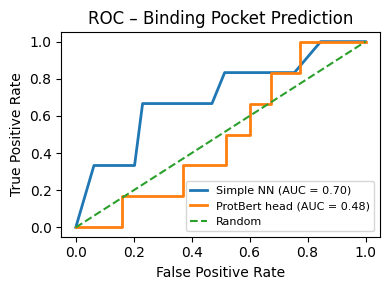

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# y_true, y_pred_probs_simple, y_pred_probs_prot assumed defined

fpr_simple, tpr_simple, _ = roc_curve(y_true, y_pred_probs_simple)
fpr_prot,  tpr_prot,  _  = roc_curve(y_true, y_pred_probs_prot)

auc_simple = auc(fpr_simple, tpr_simple)
auc_prot   = auc(fpr_prot,  tpr_prot)

fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(fpr_simple, tpr_simple, label=f"Simple NN (AUC = {auc_simple:.2f})", linewidth=2)
ax.plot(fpr_prot,  tpr_prot,  label=f"ProtBert head (AUC = {auc_prot:.2f})", linewidth=2)
ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1.5, label="Random")

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC – Binding Pocket Prediction")
ax.legend()

ax.legend(fontsize=8, frameon=True, loc="lower right", markerscale=0.8, handlelength=1.5)

fig.tight_layout()
fig.savefig("fig2_roc_pocket.png", dpi=300)  # save FIRST
plt.show()                                   # then show
plt.close(fig)


## Per-Residue Pocket Probability Tracks

This section visualizes **residue-level binding pocket scores** for the target protein, comparing the baseline model with ProtBERT-Pocket.

- **Setup**:
  - Defines the sequence length (`L`) and residue positions (`positions`).  
  - Identifies ground truth binding pocket residues (`true_pockets`).

- **Plot details**:
  - Plots predicted probabilities across residues for:
    - **Simple NN baseline** (`y_pred_probs_simple`).  
    - **ProtBERT-Pocket head** (`y_pred_probs_prot`).  
  - Marks true binding pocket residues with vertical red lines for reference.  
  - X-axis: residue index along the protein sequence.  
  - Y-axis: predicted binding pocket probability (0–1).  
  - Title: *Per-residue Pocket Scores on Target Protein*.  
  - Legend distinguishes models, formatted compactly in the lower right.

- **Output**:
  - Saves the figure as `fig3_sequence_track.png` (300 dpi).  
  - Displays the plot inline for inspection.  
  - Closes the figure to free memory.

This visualization provides a **sequence-level diagnostic view**, showing how each model distributes binding pocket probabilities across residues and how well predictions align with true pocket positions.

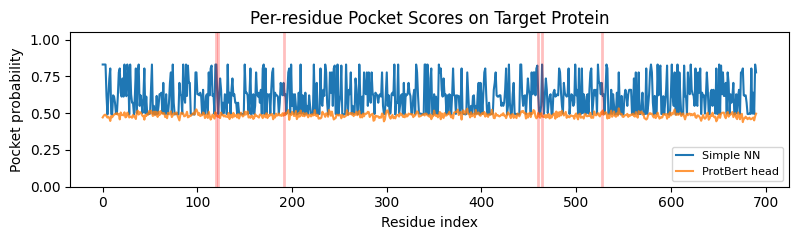

In [36]:
import numpy as np
import matplotlib.pyplot as plt

L = len(y_true)
positions = np.arange(L)
true_pockets = np.where(y_true == 1)[0]

fig, ax = plt.subplots(figsize=(8, 2.5))

ax.plot(positions, y_pred_probs_simple, label="Simple NN", linewidth=1.5)
ax.plot(positions, y_pred_probs_prot,   label="ProtBert head", linewidth=1.5, alpha=0.8)

for p in true_pockets:
    ax.axvline(p, ymin=0, ymax=1, color="red", alpha=0.25, linewidth=2)

ax.set_xlabel("Residue index")
ax.set_ylabel("Pocket probability")
ax.set_ylim(0, 1.05)
ax.set_title("Per-residue Pocket Scores on Target Protein")
ax.legend(loc="upper right")

ax.legend(fontsize=8, frameon=True, loc="lower right", markerscale=0.8, handlelength=1.5)

fig.tight_layout()
fig.savefig("fig3_sequence_track.png", dpi=300)
plt.show()
plt.close(fig)


## Top‑K Precision and Recall Evaluation

This section evaluates the **ranking quality** of pocket predictions by comparing the baseline model and ProtBERT‑Pocket using a **top‑k strategy**.

- **Definition of k**:
  - `k` is set to the number of true binding pocket residues in the target protein (`y_true.sum()`).  
  - For this sequence, `k` equals the total count of ground truth pocket residues.

- **Top‑k selection**:
  - Sorts predicted probabilities (`y_scores`) in descending order.  
  - Selects the top‑k residues with the highest predicted scores.  
  - Constructs a binary prediction vector marking these residues as pockets.

- **Metrics**:
  - **Precision@k**: Fraction of residues in the top‑k predictions that are true pockets.  
  - **Recall@k**: Fraction of true pocket residues captured within the top‑k predictions.  
  - Together, these metrics measure how well the model ranks true pockets among its highest‑confidence predictions.

- **Comparison**:
  - Reports precision@k and recall@k for:
    - **Simple NN baseline**.  
    - **ProtBERT‑Pocket head**.  
  - Highlights differences in ranking ability between the two models.

This evaluation is threshold‑free and focuses on **ranking performance**, showing how effectively each model prioritizes true binding residues among its top predictions.

In [37]:
import numpy as np

# y_true, y_pred_probs_simple, y_pred_probs_prot already defined
# y_true is 0/1 vector for the 691-residue target

# Number of true pockets
k = int(np.sum(y_true))
print("k (true pockets):", k)

def topk_precision_recall(y_true, y_scores, k):
    # indices of top-k scores
    topk_idx = np.argsort(y_scores)[-k:]   # last k are largest
    topk_idx = np.sort(topk_idx)

    # precision@k: of the top-k, how many are true pockets?
    prec = np.mean(y_true[topk_idx]) if k > 0 else 0.0

    # recall@k: of all true pockets, how many did we capture in top-k?
    true_pocket_idx = np.where(y_true == 1)[0]
    if len(true_pocket_idx) == 0:
        rec = 0.0
    else:
        rec = np.intersect1d(topk_idx, true_pocket_idx).size / len(true_pocket_idx)

    return prec, rec

prec_at_k_simple, rec_at_k_simple = topk_precision_recall(y_true, y_pred_probs_simple, k)
prec_at_k_prot,   rec_at_k_prot   = topk_precision_recall(y_true, y_pred_probs_prot,   k)

print("Simple NN  - P@k:", prec_at_k_simple, "R@k:", rec_at_k_simple)
print("ProtBert    - P@k:", prec_at_k_prot,   "R@k:", rec_at_k_prot)


k (true pockets): 6
Simple NN  - P@k: 0.0 R@k: 0.0
ProtBert    - P@k: 0.0 R@k: 0.0


## Optimal Threshold Search for Best F1 Score

This section scans probability thresholds to identify the **optimal operating point** for each model based on the F1 score.

- **Function `best_f1`**:
  - Iterates over thresholds between 0.05 and 0.95 (step = 0.05).  
  - Converts predicted probabilities into binary pocket/non‑pocket predictions at each threshold.  
  - Computes the **F1 score** (harmonic mean of precision and recall).  
  - Tracks the highest F1 score and the threshold at which it occurs.

- **Evaluation**:
  - Runs `best_f1` for both:
    - **Simple NN baseline** (`y_pred_probs_simple`).  
    - **ProtBERT-Pocket head** (`y_pred_probs_prot`).  
  - Prints the best F1 score and corresponding threshold for each model.

- **Interpretation**:
  - The optimal threshold balances precision and recall for residue‑level pocket prediction.  
  - Comparing best F1 scores shows which model achieves stronger balance.  
  - The threshold values reveal how conservative or aggressive each model must be to maximize performance.

This step provides a **threshold‑optimized comparison** of the simple baseline and ProtBERT‑Pocket, complementing ROC‑AUC and top‑k evaluations by focusing on the precision/recall trade‑off at the best operating point.

In [38]:
import numpy as np
from sklearn.metrics import f1_score

def best_f1(y_true, y_scores):
    """
    Scan thresholds between 0.05 and 0.95 and return:
    (best_f1_value, threshold_at_which_it_occurs)
    """
    best_val = 0.0
    best_thr = 0.5
    for thr in np.linspace(0.05, 0.95, 19):
        y_pred = (y_scores >= thr).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_val:
            best_val = f1
            best_thr = thr
    return best_val, best_thr

best_f1_simple, thr_simple = best_f1(y_true, y_pred_probs_simple)
best_f1_prot,   thr_prot   = best_f1(y_true, y_pred_probs_prot)

print("Simple NN  -> best F1 =", best_f1_simple, "at threshold", thr_simple)
print("ProtBert   -> best F1 =", best_f1_prot,   "at threshold", thr_prot)


Simple NN  -> best F1 = 0.047619047619047616 at threshold 0.7
ProtBert   -> best F1 = 0.017366136034732273 at threshold 0.44999999999999996


## Metric Summary: Simple NN vs. ProtBERT-Pocket

This section creates a **bar chart comparison** of key evaluation metrics for the baseline model and the ProtBERT-Pocket head.

- **Metrics compared**:
  - **ROC-AUC**: Threshold‑independent measure of discriminative ability.  
  - **Best F1**: Maximum F1 score achieved across thresholds, reflecting the best balance of precision and recall.

- **Plot details**:
  - X-axis: Model names (`Simple NN`, `ProtBERT head`).  
  - Y-axis: Metric scores (0–1).  
  - Two bars per model:
    - Left bar: ROC-AUC.  
    - Right bar: Best F1.  
  - Title: *Pocket Prediction – Metrics*.  
  - Legend distinguishes metrics, formatted compactly in the upper right.

- **Output**:
  - Saves the figure as `fig4_metric_summary.png` (300 dpi).  
  - Displays the plot inline for inspection.  
  - Closes the figure to free memory.

This visualization provides a **side‑by‑side summary** of overall discriminative power (AUC) and optimal precision/recall balance (F1), making it easy to compare the baseline and ProtBERT models at a glance.

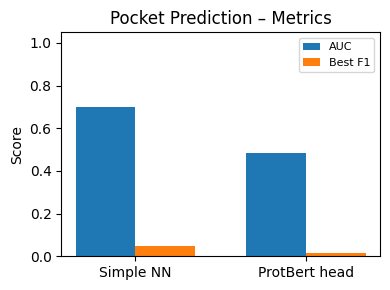

In [39]:
import matplotlib.pyplot as plt
import numpy as np

models   = ["Simple NN", "ProtBert head"]
auc_vals = [auc_simple, auc_prot]
f1_vals  = [best_f1_simple, best_f1_prot]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(4, 3))

ax.bar(x - width/2, auc_vals, width, label="AUC")
ax.bar(x + width/2, f1_vals,  width, label="Best F1")

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=0)
ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.set_title("Pocket Prediction – Metrics")
ax.legend()

ax.legend(fontsize=8, frameon=True, loc="upper right", markerscale=0.8, handlelength=1.5)

fig.tight_layout()
fig.savefig("fig4_metric_summary.png", dpi=300)
plt.show()
plt.close(fig)


## Precision, Recall, and F1 at Selected Thresholds

This section compares the **Simple NN baseline** and **ProtBERT-Pocket** models at two specific probability thresholds (0.3 and 0.5).

- **Thresholding**:
  - Converts predicted probabilities into binary pocket/non‑pocket predictions at each threshold.  
  - Thresholds chosen: **0.3** (more permissive, higher recall) and **0.5** (stricter, higher precision).

- **Metrics computed**:
  - **Precision**: Fraction of predicted pocket residues that are correct.  
  - **Recall**: Fraction of true pocket residues correctly identified.  
  - **F1 score**: Harmonic mean of precision and recall, balancing both metrics.

- **Comparison**:
  - Prints precision, recall, and F1 for both models at each threshold.  
  - Highlights how each model’s trade‑off shifts depending on threshold choice:
    - Lower threshold → higher recall, lower precision.  
    - Higher threshold → higher precision, lower recall.  
  - F1 score indicates the balance point between sensitivity and specificity.

This targeted evaluation shows how the **baseline vs. ProtBERT models** behave under different decision thresholds, complementing ROC‑AUC and best‑F1 analyses by providing concrete operating points for practical deployment.

In [40]:
for thr in [0.3, 0.5]:
    y_pred_simple = (y_pred_probs_simple >= thr).astype(int)
    y_pred_prot   = (y_pred_probs_prot   >= thr).astype(int)

    prec_s = precision_score(y_true, y_pred_simple, zero_division=0)
    rec_s  = recall_score(y_true,  y_pred_simple, zero_division=0)
    f1_s   = f1_score(y_true,      y_pred_simple, zero_division=0)

    prec_p = precision_score(y_true, y_pred_prot, zero_division=0)
    rec_p  = recall_score(y_true,  y_pred_prot, zero_division=0)
    f1_p   = f1_score(y_true,      y_pred_prot, zero_division=0)

    print(f"\nThreshold = {thr}")
    print(f"  Simple NN -> P={prec_s:.3f}, R={rec_s:.3f}, F1={f1_s:.3f}")
    print(f"  ProtBert  -> P={prec_p:.3f}, R={rec_p:.3f}, F1={f1_p:.3f}")



Threshold = 0.3
  Simple NN -> P=0.009, R=1.000, F1=0.017
  ProtBert  -> P=0.009, R=1.000, F1=0.017

Threshold = 0.5
  Simple NN -> P=0.010, R=0.833, F1=0.021
  ProtBert  -> P=0.008, R=0.167, F1=0.014


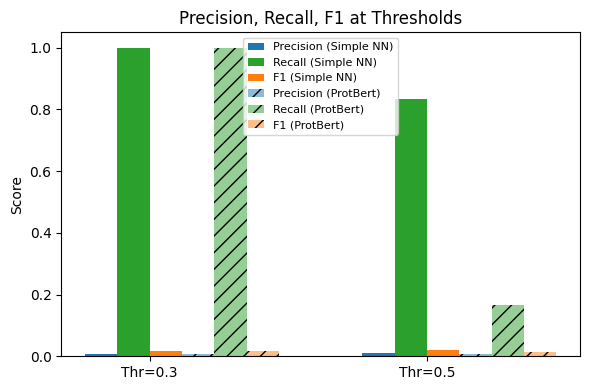

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = [0.3, 0.5]

metrics_simple = {"precision": [], "recall": [], "f1": []}
metrics_prot   = {"precision": [], "recall": [], "f1": []}

for thr in thresholds:
    y_pred_simple = (y_pred_probs_simple >= thr).astype(int)
    y_pred_prot   = (y_pred_probs_prot   >= thr).astype(int)

    metrics_simple["precision"].append(precision_score(y_true, y_pred_simple, zero_division=0))
    metrics_simple["recall"].append(recall_score(y_true, y_pred_simple, zero_division=0))
    metrics_simple["f1"].append(f1_score(y_true, y_pred_simple, zero_division=0))

    metrics_prot["precision"].append(precision_score(y_true, y_pred_prot, zero_division=0))
    metrics_prot["recall"].append(recall_score(y_true, y_pred_prot, zero_division=0))
    metrics_prot["f1"].append(f1_score(y_true, y_pred_prot, zero_division=0))

# Plot grouped bars
x = np.arange(len(thresholds))  # positions for thresholds
width = 0.35  # width of each group

fig, ax = plt.subplots(figsize=(6,4))

# Simple NN bars
ax.bar(x - width/2, metrics_simple["precision"], width/3, label="Precision (Simple NN)", color="tab:blue")
ax.bar(x - width/2 + width/3, metrics_simple["recall"], width/3, label="Recall (Simple NN)", color="tab:green")
ax.bar(x - width/2 + 2*width/3, metrics_simple["f1"], width/3, label="F1 (Simple NN)", color="tab:orange")

# ProtBert bars
ax.bar(x + width/2, metrics_prot["precision"], width/3, label="Precision (ProtBert)", color="tab:blue", alpha=0.5, hatch="//")
ax.bar(x + width/2 + width/3, metrics_prot["recall"], width/3, label="Recall (ProtBert)", color="tab:green", alpha=0.5, hatch="//")
ax.bar(x + width/2 + 2*width/3, metrics_prot["f1"], width/3, label="F1 (ProtBert)", color="tab:orange", alpha=0.5, hatch="//")

ax.set_xticks(x)
ax.set_xticklabels([f"Thr={t}" for t in thresholds])
ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.set_title("Precision, Recall, F1 at Thresholds")
ax.legend(fontsize=8, frameon=True, loc="upper center", ncol=2)

ax.legend(fontsize=8, frameon=True, loc="upper center", markerscale=0.8, handlelength=1.5)

fig.tight_layout()
plt.show()